<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/%EC%B5%9C%EC%A7%80%ED%98%84_sts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**



- 과제 목표
  - 두 개의 한국어 문장을 입력받아 두 문장의 의미적 유사도를 출력
  - regression task ( 0 <= target <= 5 ) **=> klue 결과값이 0~5이다! logit을 정규화할 필요!**
    -  as a real value from 0 (no meaning overlap) to 5 (meaning equivalence)
    - [klue](https://klue-benchmark.com/tasks/67/overview/description)
- 학습 데이터 셋 ( 다운로드 가능 & 제공 예정 )
  - KLUE-STS
    - AIRBNB ( 리뷰 )
    - policy ( 뉴스 )
    - paraKOQC ( 스마트홈 쿼리 )
- 과제 결과물
  - 학습된 모델 ( 모델 자유 선택 ) ( train set만 사용해 학습 )
  - 학습 방식 보고서
    - 어떤 모델을 선택했나
    - 어떻게 파라미터를 튜닝했나
    - 어떤 훈련 과정을 거쳤는가
  - dev set score ( F1 )
  - 문장 유사도를 출력하는 API ( 프레임워크 자유 선택 )

- [graykode/ALBERT-Pytorch](https://github.com/graykode/ALBERT-Pytorch)
- [huggingface](https://huggingface.co/docs/transformers/model_doc/albert)
- [korsts](https://github.com/kakaobrain/KorNLUDatasets)


유사도 계산.. 순서는 상관없는 것 같다..

albert가 sop(문장 순서 예측)을 통해 모델을 훈련하기 때문에 사용하려고 했는데, 유사도만 계산하는 것이기 때문에 albert를 사용할 때 장점이 크지는 않을 것 같다.

해야할 부분 

1. 하이퍼파라미터 조정
2. 보고서 작성

In [ ]:
!pip install optuna
!pip install pytorch-transformers
!pip install transformers
!pip install datasets

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
from scipy import stats
import time
import matplotlib.pyplot as plt

In [2]:
# gpu 연산이 가능하면 'cuda:0', 아니면 'cpu' 출력
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda', index=0), 1)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from transformers import BertForNextSentencePrediction, AutoTokenizer, BertConfig
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

- "klue/roberta-large"
- "klue/roberta-small"
- "klue/roberta-base"
- "klue/bert-base"
- [klue에 등록된 모델](https://huggingface.co/klue)
- [한국어언어모델](https://littlefoxdiary.tistory.com/81)

# Load dataset

### KLUE 데이터셋

[klue-sts-벤치마크-구조-보기](https://velog.io/@soyoun9798/KLUE-STS-%EB%B2%A4%EC%B9%98%EB%A7%88%ED%81%AC-%EA%B5%AC%EC%A1%B0-%EB%B3%B4%EA%B8%B0)


In [5]:
from datasets import load_dataset
dataset = load_dataset('klue', 'sts')

Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
print(f"type(dataset) : {type(dataset)}")
print(f"key : {dataset.keys()}")
print(f"type dataset[train] : {type(dataset['train'])}")
print(f"dataset[train] : {dataset['train']} \n\n")
# labels : { 이진분류 : 1, 반올림 값 : 3.7, 실제 label 값 : 3.71422... }
dataset['train'][0]

type(dataset) : <class 'datasets.dataset_dict.DatasetDict'>
key : dict_keys(['train', 'validation'])
type dataset[train] : <class 'datasets.arrow_dataset.Dataset'>
dataset[train] : Dataset({
    features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
    num_rows: 11668
}) 




{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [7]:
# 데이터 10개만 확인
i = 0
for d in dataset['train'] :
  if i == 10 : break
  print(d)
  i += 1

{'guid': 'klue-sts-v1_train_00000', 'source': 'airbnb-rtt', 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.', 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.', 'labels': {'label': 3.7, 'real-label': 3.714285714285714, 'binary-label': 1}}
{'guid': 'klue-sts-v1_train_00001', 'source': 'policy-sampled', 'sentence1': '위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.', 'sentence2': '시민들 스스로 자발적인 예방 노력을\xa0한 것은 아산 뿐만이 아니었다.', 'labels': {'label': 0.0, 'real-label': 0.0, 'binary-label': 0}}
{'guid': 'klue-sts-v1_train_00002', 'source': 'paraKQC-sampled', 'sentence1': '회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.', 'sentence2': '사람들이 주로 네이버 메일을 쓰는 이유를 알려줘', 'labels': {'label': 0.3, 'real-label': 0.3333333333333333, 'binary-label': 0}}
{'guid': 'klue-sts-v1_train_00003', 'source': 'policy-sampled', 'sentence1': '긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업성공패키지, 청년구직활동지원금, 긴급복지지원제도 지원금과는 중복 수급이 불가능하다.', 'sentence2': '고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.', 'labels': {'label': 0.6, 'real-la

### kor_nlu sts dataset



In [8]:
kor_nlu_data = load_dataset("kor_nlu", "sts")

Reusing dataset kor_nlu (/root/.cache/huggingface/datasets/kor_nlu/sts/1.0.0/4facbba77df60b0658056ced2052633e681a50187b9428bd5752ebd59d332ba8)


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
print(f"type(dataset) : {type(kor_nlu_data)}")
print(f"key : {kor_nlu_data.keys()}")
print(f"type dataset[train] : {type(kor_nlu_data['train'])}")
print(f"kor_nlu_data[train] : {kor_nlu_data['train']} \n\n")
# labels : { 이진분류 : 1, 반올림 값 : 3.7, 실제 label 값 : 3.71422... }
kor_nlu_data['train'][0]

type(dataset) : <class 'datasets.dataset_dict.DatasetDict'>
key : dict_keys(['train', 'validation', 'test'])
type dataset[train] : <class 'datasets.arrow_dataset.Dataset'>
kor_nlu_data[train] : Dataset({
    features: ['genre', 'filename', 'year', 'id', 'score', 'sentence1', 'sentence2'],
    num_rows: 5703
}) 




{'filename': 2,
 'genre': 1,
 'id': 1,
 'score': 5.0,
 'sentence1': '비행기가 이륙하고 있다.',
 'sentence2': '비행기가 이륙하고 있다.',
 'year': 6}

# Dataset Tokenizing -> dataLoader

In [10]:
import re
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataset, appended_data=None, appended_data2=None):
        self.sentence1, self.sentence2, self.labels = self.make_dataset(dataset, appended_data, appended_data2)
        # self.make_dataset(dataset, appended_data)

    def make_dataset(self, dataset, appended_data=None, appended_data2=None):
        """
        self.label : dataset의 label의 list
        self.input : sentence1, sentence2를 tokenizer한 값을 이어 붙임 
        rlabels : # real-label
        """
        sentence1, sentence2, rlabels = [], [], []

        for data in dataset :
          rlabels.append(data['labels']['real-label'])
          sentence1.append(self.cleaning(data['sentence1']))
          sentence2.append(self.cleaning(data['sentence2']))

        if appended_data is not None :
          for data in appended_data :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue 
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))

        if appended_data2 is not None :
          for data in appended_data2 :
            if data['score'] is None or data['sentence1'] is None or data['sentence2'] is None :
              continue
            rlabels.append(data['score'])
            sentence1.append(self.cleaning(data['sentence1']))
            sentence2.append(self.cleaning(data['sentence2']))
        return sentence1, sentence2, rlabels
        
    def __len__(self):
        # return len(self.tensorized_input)
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentence1[idx], self.sentence2[idx], self.labels[idx]
        # return self.tensorized_input[idx], self.tensorized_label[idx]

    def cleaning(self, sentence) :
        return re.sub('[^가-힣]','', sentence)

In [12]:
def custom_collate_fn(batch):
    input1_list, input2_list, target_list = [], [], []

    for _input1, _input2, _target in batch:
        input1_list.append(_input1)
        input2_list.append(_input2)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input1_list, input2_list,
        add_special_tokens=True,
        padding="longest",  # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    tensorized_label = torch.tensor(target_list)

    return tensorized_input, tensorized_label

In [13]:
# 1. 32, 32
def make_dataloader(dataset, tok_model, batch_size, s='train') :
  global tokenizer
  tokenizer = AutoTokenizer.from_pretrained(tok_model)
  if s == 'train' :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = RandomSampler(dataset),
        collate_fn = custom_collate_fn
    )
  else :
    dataloader = DataLoader(
        dataset,
        batch_size =batch_size,
        sampler = SequentialSampler(dataset),
        collate_fn = custom_collate_fn
    )
  print(f'batch_size : {batch_size}')
  return dataloader

# model class

In [14]:
# 모델 클래스
class CustomSTS(nn.Module):
    def __init__(self, hidden_size: int, model_name):
        super(CustomSTS, self).__init__()
        self.bert_config = BertConfig.from_pretrained(model_name)   
        self.model = BertForNextSentencePrediction.from_pretrained(model_name, config=self.bert_config)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        """
        outputs(NextSentencePredictorOutput) : logtis, loss(next_sentence_label이 주어질 때 return)
                                              hidden_states(optional), attentions(optional) 을 가지고 있다.
        loss는 주어진 label이 0~5 사이의 값으로 scale 되어있기 때문에 직접 구해야한다!
        """
        # logits's shape : (batch_size, 2)
        logits = self.model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        ).logits
        probs = self.softmax(logits)
        probs = probs[:, 0] * 5    # 0~5 사이의 값으로 정답(T)일 확률 뽑아내기
        return probs    # 정답(T)일 확률, 정답일때 1 

# train

### model, optimizer, scheduler 초기화

In [15]:
def initializer(train_dataloader, epochs=2, model_name='snunlp/KR-Medium', lr=4e-5, wd=4e-5):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    model = CustomSTS(hidden_size=768, model_name=model_name)   # hidden size?

    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=lr,    # 2e-5
        eps=1e-8,
        weight_decay=wd
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )
    print(f'model_name : {model_name}, lr : {lr}, weight_decay : {wd}, epochs : {epochs}')
    return model, optimizer, scheduler

### checkpoint

In [16]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss, f1, model_name=''):
    file_name = f'{path}/epoch:{epoch}_loss:{loss:.4f}_f1:{f1:.4f}.ckpt'
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss,
            'f1' : f1
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

### train code

In [17]:
def train(model, optimizer, scheduler, train_dataloader, valid_dataloader=None, epochs=1, model_name=''):
  loss_fct = nn.MSELoss()
  train_dict = {'loss' : [], 'f1' : []}
  valid_dict = {'loss' : [], 'f1' : [], 'pearson' : []}
  global before_loss, before_f1
  before_loss, before_f1 = 0.4, 0.7
  for epoch in range(epochs) :

    print(f"*****Epoch {epoch} Train Start*****")
    # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
    total_loss, total_f1, batch_f1, batch_loss, batch_count = 0,0,0,0,0
    
    # model을 train 모드로 설정 & device 할당
    model.train()
    model.to(device)
    
    # data iterator를 돌면서 하나씩 학습
    for step, batch in enumerate(train_dataloader):
      batch_count+=1
      
      # tensor 연산 전, 각 tensor에 device 할당
      batch = tuple(item.to(device) for item in batch)
      
      batch_input, batch_label = batch
      
      # batch마다 모델이 갖고 있는 기존 gradient를 초기화/??
      model.zero_grad()
      
      # forward
      probs = model(**batch_input)

      # loss
      loss = loss_fct(probs, batch_label)
      batch_loss += loss.item()
      total_loss += loss.item()

      # f1-score
      f1 = f1_score([0 if p < 3 else 1 for p in batch_label], [0 if p < 3 else 1 for p in probs])
      batch_f1 += f1
      total_f1 += f1

      # backward -> 파라미터의 미분(gradient)를 자동으로 계산
      loss.backward()

      # gradient clipping 적용 
      clip_grad_norm_(model.parameters(), 1.0)
      
      # optimizer & scheduler 업데이트
      optimizer.step()
      scheduler.step()

      # 그래디언트 초기화
      model.zero_grad()

      # 배치 64개씩 처리할 때마다 평균 loss와 lr를 출력
      if (step % 64 == 0 and step != 0):
          learning_rate = optimizer.param_groups[0]['lr']
          print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate:.10f}, Avg Loss : {batch_loss / batch_count:.4f}, f1 score : {batch_f1 / batch_count:.4f}")
          
          if (round(batch_f1 / batch_count, 5) == 0) and (round(learning_rate, 10) == 0) :
              print("Train Finished, learning_rate is 0 and train_f1 is 0")
              return train_dict, valid_dict

          # 변수 초기화
          batch_loss, batch_f1, batch_count = 0,0,0


    print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
    print(f"Epoch {epoch} Total Mean f1 : {total_f1/(step+1):.4f}")
    print(f"*****Epoch {epoch} Train Finish*****\n")

    train_dict['f1'].append(total_f1/(step+1))
    train_dict['loss'].append(total_loss/(step+1))
    
    if valid_dataloader is not None:
        print(f"*****Epoch {epoch} Valid Start*****")
        valid_loss, valid_acc, valid_f1, valid_pearson = validate(model, valid_dataloader)
        print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.4f} Valid f1 : {valid_f1:.4f}")
        print(f"pearson 상관 계수 ; {valid_pearson}")
        print(f"*****Epoch {epoch} Valid Finish*****\n")

    valid_dict['f1'].append(valid_f1)
    valid_dict['loss'].append(valid_loss)

    if before_loss > valid_loss :
        before_loss = valid_loss
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

    elif before_f1 < valid_f1  :
        before_f1 = valid_f1
        save_checkpoint("/content/drive/MyDrive/Colab Notebooks/nlp", model, optimizer, scheduler, epoch, valid_loss, valid_f1, model_name)

  print("Train Finished")
  return train_dict, valid_dict

### validation code

In [18]:
def validate(model, valid_dataloader):
    loss_fct = nn.MSELoss()
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc, total_f1, total_pearson= 0,0, 0, 0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # gradient 계산하지 않음
        with torch.no_grad():
            probs = model(**batch_input)
            
        # loss
        loss = loss_fct(probs, batch_label)
        total_loss += loss.item()
        
        # accuracy
        acc = 0
        for p, b in zip(probs, batch_label) :
          if (p > 3 and b > 3) or (p < 3 and b < 3 ) :
            acc += 1
        
        acc = acc / len(probs)
        total_acc+=acc
        
        # pearsonr 상관계수
        pearson = torch.corrcoef(torch.stack([probs, batch_label], dim=0))
        total_pearson += pearson

        # f1-score
        f1 = f1_score([0 if p < 3 else 1 for p in batch_label], [0 if p < 3 else 1 for p in probs])
        total_f1 += f1

    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)
    total_f1 = total_f1/(step+1)
    total_pearson = total_pearson/(step+1)
    return total_loss, total_acc, total_f1, total_pearson

### draw_plot

In [21]:
def draw_plot(train_dict, valid_dict, i) :
  print('green is loss, gray is f1')
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Train data')
  x_values= [n for n in range(len(train_dict['loss']))]
  plt.plot(x_values, train_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, train_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.title('Loss and F1 of Validation data')
  x_values= [n for n in range(len(valid_dict['loss']))]
  plt.plot(x_values, valid_dict['loss'], color='green', marker='o')  # loss
  plt.plot(x_values, valid_dict['f1'], color='#AAAAAA', marker='*')  # f1

  plt.show()
  plt.savefig(f'figure_{i}.png')

# hyperparameter 조정

[optuna 사용법](https://dacon.io/codeshare/2704)

- transformer의 trainer 사용
  - [trainer huggingface](https://huggingface.co/docs/transformers/main_classes/trainer)
  - [bert에 optuna 사용법-medium](https://medium.com/carbon-consulting/transformer-models-hyperparameter-optimization-with-the-optuna-299e185044a8)
  - [bert에 optuna 사용법-git블로그](https://thigm85.github.io/blog/search/cord19/bert/transformers/optuna/2020/11/07/bert-training-optuna-tuning.html)


In [19]:
import optuna

In [32]:
i = 0
def objective(trial: optuna.Trial):
    train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64])
    model_name = 'monologg/kobert'  #trial.suggest_categorical("model_name", ["snunlp/KR-Medium", 'klue/bert-base'])    # 2가지만 비교!
    
    train_dataloader = make_dataloader(train_dataset, model_name, train_batch_size, 'train')
    valid_dataloader = make_dataloader(valid_dataset, model_name, 32, 'valid')

    learning_rate = trial.suggest_categorical('learning_rate', [5e-5, 3e-5, 2e-5, 1e-6, 1e-3])  # trial.suggest_loguniform('learning_rate', low=1e-6, high=0.01)
    weight_decay = trial.suggest_categorical('weight_decay', [4e-5, 0.01]) # trial.suggest_categorical('weight_decay', [1e-5, 0.0001, 0.001, 0.01])

    # num_train_epochs = trial.suggest_int('num_train_epochs', low = 1,high= 20)
    model, optimizer, scheduler = initializer(train_dataloader, 1, model_name, learning_rate, weight_decay)   # 여기에 config 선언되어있다.

    start = time.time()
    train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 4, model_name)
    end = time.time()
    print(f"time : {(end - start)//60}분 {(end - start)%60}초")

    global i

    draw_plot(train_dict, valid_dict, i)
    i += 1

    gc.collect()
    print('\n------------------------------------------\n\n')
    return max(valid_dict['f1'])

In [23]:
train_dataset = CustomDataset(dataset['train'], kor_nlu_data['train'])
valid_dataset = CustomDataset(dataset['validation'], kor_nlu_data['validation'], kor_nlu_data['test'])  # 확인!!

In [33]:
import gc
gc.collect()

338

### klue/bert-base
- train_batch_size = [16, 32, 64]
- valid_batch_size = 32
- learning_rate = [5e-5, 3e-5, 2e-5, 1e-6, 1e-3]
- weight_decay = [4e-5, 0.01]

1. 32, 32, 0.001, 4e-05 -> 0.0
2. 64, 32, 1e-06, 4e-05 -> 0.6599

[I 2022-05-31 09:07:23,225] A new study created in memory with name: hyper-parameter-search


klue/bert-base


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.6454, f1 score : 0.0815
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.0807, f1 score : 0.0835
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 2.8876, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9812, f1 score : 0.0309
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9102, f1 score : 0.0171
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8979, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.9341, f1 score : 0.0547
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8105, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0120
Epoch 0 Total Mean f1 : 0.0317
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3067 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0032],
        [-0.0032,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7489, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 17.22834038734436초
green is loss, gray is f1


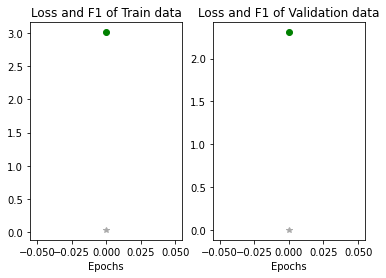

[I 2022-05-31 09:10:57,649] Trial 0 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : klue/bert-base, lr : 1e-06, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000007610, Avg Loss : 7.0650, f1 score : 0.7031
Epoch: 0, Step : 128, LR : 0.0000005257, Avg Loss : 3.9110, f1 score : 0.7494
Epoch: 0, Step : 192, LR : 0.0000002904, Avg Loss : 1.8740, f1 score : 0.7481
Epoch: 0, Step : 256, LR : 0.0000000551, Avg Loss : 1.5069, f1 score : 0.7485
Epoch 0 Total Mean Loss : 3.4839
Epoch 0 Total Mean f1 : 0.7385
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.2514 Valid Acc : 0.6536 Valid f1 : 0.6599
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 1.4377, f1 score : 0.7524
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 1.3726, f1 score : 0.7599
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 1.4273, f1 score : 0.7554
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 1.5024, f1 score : 0.7519
Epoch 1 Total Mean Loss : 1.4310
Epoch 1 Total Mean f1 : 0.7553
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 2.2514 Valid Acc : 0.6536 Valid f1 : 0.6599
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 1.4304, f1 score : 0.7492
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 1.4396, f1 score : 0.7522
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 1.4336, f1 score : 0.7507
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 1.3823, f1 score : 0.7708
Epoch 2 Total Mean Loss : 1.4219
Epoch 2 Total Mean f1 : 0.7530
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 2.2514 Valid Acc : 0.6536 Valid f1 : 0.6599
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 1.4428, f1 score : 0.7493
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 1.3854, f1 score : 0.7646
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 1.3662, f1 score : 0.7660
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 1.4822, f1 score : 0.7384
Epoch 3 Total Mean Loss : 1.4190
Epoch 3 Total Mean f1 : 0.7550
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 2.2514 Valid Acc : 0.6536 Valid f1 : 0.6599
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 6.070347547531128초
green is loss, gray is f1


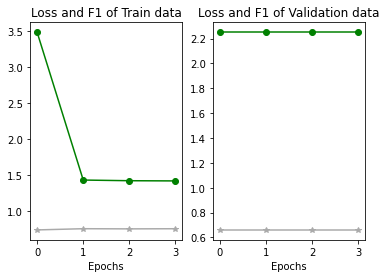

[I 2022-05-31 09:22:20,698] Trial 1 finished with value: 0.6599229701766901 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 1e-06, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.5431, f1 score : 0.1006
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.8634, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8683, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8617, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0259
Epoch 0 Total Mean f1 : 0.0240
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3047 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8285, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 23.77639365196228초
green is loss, gray is f1


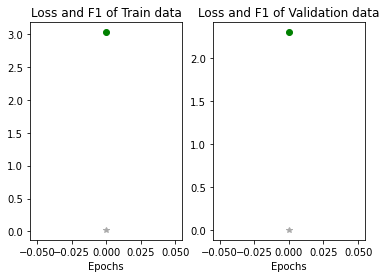

[I 2022-05-31 09:26:01,430] Trial 2 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 2e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000176059, Avg Loss : 1.6091, f1 score : 0.7809
Epoch: 0, Step : 128, LR : 0.0000152486, Avg Loss : 0.7470, f1 score : 0.8361
Epoch: 0, Step : 192, LR : 0.0000128913, Avg Loss : 0.6487, f1 score : 0.8398
Epoch: 0, Step : 256, LR : 0.0000105341, Avg Loss : 0.5390, f1 score : 0.8672
Epoch: 0, Step : 320, LR : 0.0000081768, Avg Loss : 0.5765, f1 score : 0.8699
Epoch: 0, Step : 384, LR : 0.0000058195, Avg Loss : 0.6024, f1 score : 0.8535
Epoch: 0, Step : 448, LR : 0.0000034622, Avg Loss : 0.5944, f1 score : 0.8613
Epoch: 0, Step : 512, LR : 0.0000011050, Avg Loss : 0.5658, f1 score : 0.8703
Epoch 0 Total Mean Loss : 0.7256
Epoch 0 Total Mean f1 : 0.8478
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.9533 Valid Acc : 0.7647 Valid f1 : 0.7165
pearson 상관 계수 ; tensor([[1.0000, 0.7216],
        [0.7216, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.9533_f1:0.7165.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.4849, f1 score : 0.8706
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.4303, f1 score : 0.8956
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.4658, f1 score : 0.8884
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.4180, f1 score : 0.8851
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3981, f1 score : 0.8908
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.4283, f1 score : 0.8944
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.4730, f1 score : 0.8731
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.4594, f1 score : 0.8956
Epoch 1 Total Mean Loss : 0.4420
Epoch 1 Total Mean f1 : 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.9533 Valid Acc : 0.7647 Valid f1 : 0.7165
pearson 상관 계수 ; tensor([[1.0000, 0.7216],
        [0.7216, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.4383, f1 score : 0.8952
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.4374, f1 score : 0.8970
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.4390, f1 score : 0.8851
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.4506, f1 score : 0.8854
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.4237, f1 score : 0.8765
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.4306, f1 score : 0.8812
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.4739, f1 score : 0.8836
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.4368, f1 score : 0.8806
Epoch 2 Total Mean Loss : 0.4395
Epoch 2 Total Mean f1 : 0.8861
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.9533 Valid Acc : 0.7647 Valid f1 : 0.7165
pearson 상관 계수 ; tensor([[1.0000, 0.7216],
        [0.7216, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.4297, f1 score : 0.8756
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.4134, f1 score : 0.8989
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.4748, f1 score : 0.8744
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.4370, f1 score : 0.8908
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.4964, f1 score : 0.8744
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.4145, f1 score : 0.8841
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.4469, f1 score : 0.8741
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.4083, f1 score : 0.8950
Epoch 3 Total Mean Loss : 0.4399
Epoch 3 Total Mean f1 : 0.8844
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.9533 Valid Acc : 0.7647 Valid f1 : 0.7165
pearson 상관 계수 ; tensor([[1.0000, 0.7216],
        [0.7216, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 41.748130321502686초
green is loss, gray is f1


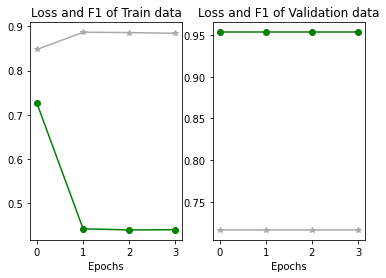

[I 2022-05-31 09:38:00,175] Trial 3 finished with value: 0.7164845076126242 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 2e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 2e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000176059, Avg Loss : 1.4192, f1 score : 0.8027
Epoch: 0, Step : 128, LR : 0.0000152486, Avg Loss : 0.7094, f1 score : 0.8408
Epoch: 0, Step : 192, LR : 0.0000128913, Avg Loss : 0.6080, f1 score : 0.8560
Epoch: 0, Step : 256, LR : 0.0000105341, Avg Loss : 0.5918, f1 score : 0.8589
Epoch: 0, Step : 320, LR : 0.0000081768, Avg Loss : 0.5896, f1 score : 0.8671
Epoch: 0, Step : 384, LR : 0.0000058195, Avg Loss : 0.6334, f1 score : 0.8551
Epoch: 0, Step : 448, LR : 0.0000034622, Avg Loss : 0.5462, f1 score : 0.8616
Epoch: 0, Step : 512, LR : 0.0000011050, Avg Loss : 0.5467, f1 score : 0.8631
Epoch 0 Total Mean Loss : 0.7004
Epoch 0 Total Mean f1 : 0.8517
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.9369 Valid Acc : 0.7642 Valid f1 : 0.6951
pearson 상관 계수 ; tensor([[1.0000, 0.7275],
        [0.7275, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.4625, f1 score : 0.8857
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.4554, f1 score : 0.8818
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.4488, f1 score : 0.8842
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.4154, f1 score : 0.8791
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.4547, f1 score : 0.8792
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.4649, f1 score : 0.8799
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.4281, f1 score : 0.8727
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.4432, f1 score : 0.8729
Epoch 1 Total Mean Loss : 0.4470
Epoch 1 Total Mean f1 : 0.8791
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.9369 Valid Acc : 0.7642 Valid f1 : 0.6951
pearson 상관 계수 ; tensor([[1.0000, 0.7275],
        [0.7275, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.4712, f1 score : 0.8704
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.4425, f1 score : 0.8748
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.4687, f1 score : 0.8891
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.4290, f1 score : 0.8818
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.4626, f1 score : 0.8648
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3891, f1 score : 0.8799
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.4438, f1 score : 0.8710
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.4364, f1 score : 0.8781
Epoch 2 Total Mean Loss : 0.4407
Epoch 2 Total Mean f1 : 0.8764
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.9369 Valid Acc : 0.7642 Valid f1 : 0.6951
pearson 상관 계수 ; tensor([[1.0000, 0.7275],
        [0.7275, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.4229, f1 score : 0.8803
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.4334, f1 score : 0.8850
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.4733, f1 score : 0.8696
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.4464, f1 score : 0.8760
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.4588, f1 score : 0.8795
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.4666, f1 score : 0.8780
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.4554, f1 score : 0.8746
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.4500, f1 score : 0.8852
Epoch 3 Total Mean Loss : 0.4486
Epoch 3 Total Mean f1 : 0.8789
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.9369 Valid Acc : 0.7642 Valid f1 : 0.6951
pearson 상관 계수 ; tensor([[1.0000, 0.7275],
        [0.7275, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 38.017099142074585초
green is loss, gray is f1


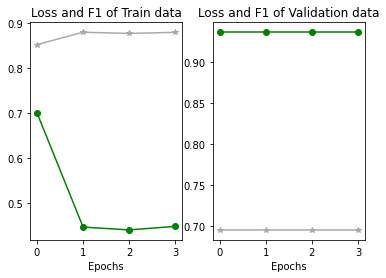

[I 2022-05-31 09:49:55,118] Trial 4 finished with value: 0.6951097328428413 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 2e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : klue/bert-base, lr : 5e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000380515, Avg Loss : 1.2043, f1 score : 0.7827
Epoch: 0, Step : 128, LR : 0.0000262868, Avg Loss : 0.6174, f1 score : 0.8682
Epoch: 0, Step : 192, LR : 0.0000145221, Avg Loss : 0.5851, f1 score : 0.8679
Epoch: 0, Step : 256, LR : 0.0000027574, Avg Loss : 0.5095, f1 score : 0.8702
Epoch 0 Total Mean Loss : 0.7201
Epoch 0 Total Mean f1 : 0.8466
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.9018 Valid Acc : 0.7706 Valid f1 : 0.7163
pearson 상관 계수 ; tensor([[1.0000, 0.7357],
        [0.7357, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.9018_f1:0.7163.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3768, f1 score : 0.9061
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3886, f1 score : 0.9019
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.4002, f1 score : 0.8929
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3884, f1 score : 0.8939
Epoch 1 Total Mean Loss : 0.3871
Epoch 1 Total Mean f1 : 0.8985
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.9018 Valid Acc : 0.7706 Valid f1 : 0.7163
pearson 상관 계수 ; tensor([[1.0000, 0.7357],
        [0.7357, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3818, f1 score : 0.8985
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3781, f1 score : 0.8985
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3840, f1 score : 0.8963
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.4139, f1 score : 0.8889
Epoch 2 Total Mean Loss : 0.3872
Epoch 2 Total Mean f1 : 0.8955
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.9018 Valid Acc : 0.7706 Valid f1 : 0.7163
pearson 상관 계수 ; tensor([[1.0000, 0.7357],
        [0.7357, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3693, f1 score : 0.9022
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3871, f1 score : 0.8967
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3731, f1 score : 0.9011
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.4128, f1 score : 0.8939
Epoch 3 Total Mean Loss : 0.3836
Epoch 3 Total Mean f1 : 0.8981
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.9018 Valid Acc : 0.7706 Valid f1 : 0.7163
pearson 상관 계수 ; tensor([[1.0000, 0.7357],
        [0.7357, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 10.949833393096924초
green is loss, gray is f1


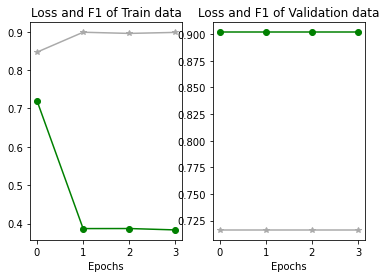

[I 2022-05-31 10:01:23,092] Trial 5 finished with value: 0.7162724317631566 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 5e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : klue/bert-base, lr : 1e-06, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000007610, Avg Loss : 7.2244, f1 score : 0.6927
Epoch: 0, Step : 128, LR : 0.0000005257, Avg Loss : 3.5795, f1 score : 0.7661
Epoch: 0, Step : 192, LR : 0.0000002904, Avg Loss : 1.8595, f1 score : 0.7353
Epoch: 0, Step : 256, LR : 0.0000000551, Avg Loss : 1.4589, f1 score : 0.7459
Epoch 0 Total Mean Loss : 3.4339
Epoch 0 Total Mean f1 : 0.7357
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.2093 Valid Acc : 0.6509 Valid f1 : 0.6589
pearson 상관 계수 ; tensor([[1.0000, 0.5138],
        [0.5138, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 1.3553, f1 score : 0.7600
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 1.4254, f1 score : 0.7502
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 1.3985, f1 score : 0.7561
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 1.3521, f1 score : 0.7607
Epoch 1 Total Mean Loss : 1.3846
Epoch 1 Total Mean f1 : 0.7566
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 2.2093 Valid Acc : 0.6509 Valid f1 : 0.6589
pearson 상관 계수 ; tensor([[1.0000, 0.5138],
        [0.5138, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 1.3447, f1 score : 0.7650
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 1.4408, f1 score : 0.7555
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 1.4455, f1 score : 0.7520
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 1.3949, f1 score : 0.7544
Epoch 2 Total Mean Loss : 1.4046
Epoch 2 Total Mean f1 : 0.7572
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 2.2093 Valid Acc : 0.6509 Valid f1 : 0.6589
pearson 상관 계수 ; tensor([[1.0000, 0.5138],
        [0.5138, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 1.4100, f1 score : 0.7563
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 1.4214, f1 score : 0.7557
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 1.3665, f1 score : 0.7663
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 1.3945, f1 score : 0.7648
Epoch 3 Total Mean Loss : 1.3965
Epoch 3 Total Mean f1 : 0.7604
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 2.2093 Valid Acc : 0.6509 Valid f1 : 0.6589
pearson 상관 계수 ; tensor([[1.0000, 0.5138],
        [0.5138, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 7.30175256729126초
green is loss, gray is f1


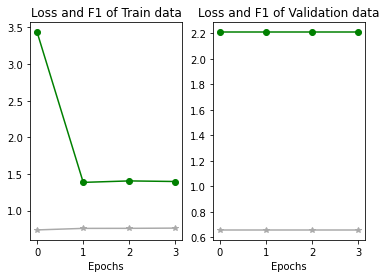

[I 2022-05-31 10:12:47,428] Trial 6 finished with value: 0.6588775622985373 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 1e-06, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.5393, f1 score : 0.1006
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.8916, f1 score : 0.0054
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.9112, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8744, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0470
Epoch 0 Total Mean f1 : 0.0253
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3226 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8391, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 26.507456064224243초
green is loss, gray is f1


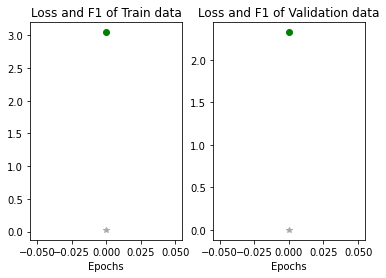

[I 2022-05-31 10:16:31,156] Trial 7 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : klue/bert-base, lr : 1e-06, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000007610, Avg Loss : 6.8203, f1 score : 0.7080
Epoch: 0, Step : 128, LR : 0.0000005257, Avg Loss : 3.8532, f1 score : 0.7562
Epoch: 0, Step : 192, LR : 0.0000002904, Avg Loss : 1.8977, f1 score : 0.7450
Epoch: 0, Step : 256, LR : 0.0000000551, Avg Loss : 1.4513, f1 score : 0.7432
Epoch 0 Total Mean Loss : 3.4028
Epoch 0 Total Mean f1 : 0.7396
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.2137 Valid Acc : 0.6524 Valid f1 : 0.6587
pearson 상관 계수 ; tensor([[1.0000, 0.5111],
        [0.5111, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 1.3429, f1 score : 0.7568
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 1.4548, f1 score : 0.7554
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 1.4043, f1 score : 0.7608
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 1.3566, f1 score : 0.7501
Epoch 1 Total Mean Loss : 1.3985
Epoch 1 Total Mean f1 : 0.7535
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 2.2137 Valid Acc : 0.6524 Valid f1 : 0.6587
pearson 상관 계수 ; tensor([[1.0000, 0.5111],
        [0.5111, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 1.4404, f1 score : 0.7652
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 1.3857, f1 score : 0.7582
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 1.4034, f1 score : 0.7433
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 1.3903, f1 score : 0.7578
Epoch 2 Total Mean Loss : 1.4077
Epoch 2 Total Mean f1 : 0.7558
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 2.2137 Valid Acc : 0.6524 Valid f1 : 0.6587
pearson 상관 계수 ; tensor([[1.0000, 0.5111],
        [0.5111, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 1.3585, f1 score : 0.7673
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 1.5165, f1 score : 0.7395
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 1.4325, f1 score : 0.7541
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 1.3386, f1 score : 0.7517
Epoch 3 Total Mean Loss : 1.4134
Epoch 3 Total Mean f1 : 0.7523
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 2.2137 Valid Acc : 0.6524 Valid f1 : 0.6587
pearson 상관 계수 ; tensor([[1.0000, 0.5111],
        [0.5111, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 9.46466851234436초
green is loss, gray is f1


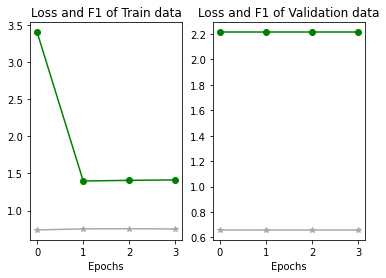

[I 2022-05-31 10:27:57,821] Trial 8 finished with value: 0.6586786360173928 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 1e-06, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : klue/bert-base, lr : 1e-06, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000007610, Avg Loss : 7.0081, f1 score : 0.7015
Epoch: 0, Step : 128, LR : 0.0000005257, Avg Loss : 3.9025, f1 score : 0.7462
Epoch: 0, Step : 192, LR : 0.0000002904, Avg Loss : 1.8743, f1 score : 0.7423
Epoch: 0, Step : 256, LR : 0.0000000551, Avg Loss : 1.5148, f1 score : 0.7551
Epoch 0 Total Mean Loss : 3.4598
Epoch 0 Total Mean f1 : 0.7382
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.2792 Valid Acc : 0.6524 Valid f1 : 0.6605
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 1.4289, f1 score : 0.7511
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 1.4125, f1 score : 0.7504
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 1.3982, f1 score : 0.7627
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 1.4739, f1 score : 0.7524
Epoch 1 Total Mean Loss : 1.4327
Epoch 1 Total Mean f1 : 0.7522
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 2.2792 Valid Acc : 0.6524 Valid f1 : 0.6605
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 1.4319, f1 score : 0.7591
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 1.4259, f1 score : 0.7616
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 1.4624, f1 score : 0.7479
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 1.3810, f1 score : 0.7612
Epoch 2 Total Mean Loss : 1.4258
Epoch 2 Total Mean f1 : 0.7582
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 2.2792 Valid Acc : 0.6524 Valid f1 : 0.6605
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 1.4111, f1 score : 0.7589
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 1.4340, f1 score : 0.7499
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 1.4604, f1 score : 0.7621
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 1.3780, f1 score : 0.7616
Epoch 3 Total Mean Loss : 1.4291
Epoch 3 Total Mean f1 : 0.7560
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 2.2792 Valid Acc : 0.6524 Valid f1 : 0.6605
pearson 상관 계수 ; tensor([[1.0000, 0.5121],
        [0.5121, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 7.726532936096191초
green is loss, gray is f1


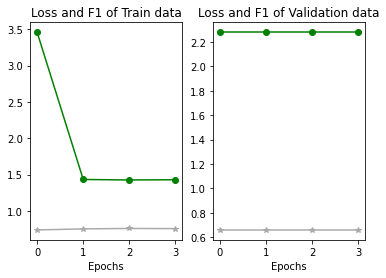

[I 2022-05-31 10:39:22,532] Trial 9 finished with value: 0.6604505073004829 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 1e-06, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : klue/bert-base, lr : 3e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 1.5813, f1 score : 0.7301
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 0.8584, f1 score : 0.8153
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 0.7550, f1 score : 0.8426
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 0.6108, f1 score : 0.8513
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 0.6556, f1 score : 0.8461
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 0.6113, f1 score : 0.8373
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 0.6368, f1 score : 0.8536
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 0.6064, f1 score : 0.8466
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 0.5943, f1 score : 0.8544
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 0.5997, f1 score : 0.8568
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 0.6273, f1 score : 0.8624
E

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.8906 Valid Acc : 0.7754 Valid f1 : 0.7150
pearson 상관 계수 ; tensor([[1.0000, 0.7398],
        [0.7398, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.8906_f1:0.7150.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3431, f1 score : 0.8917
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3939, f1 score : 0.8963
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3578, f1 score : 0.8959
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3229, f1 score : 0.9195
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3125, f1 score : 0.9027
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3655, f1 score : 0.8988
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3225, f1 score : 0.9199
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3732, f1 score : 0.8822
Epoch: 1, Step : 576, LR : 0.0000000000, Avg Loss : 0.396

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.8906 Valid Acc : 0.7754 Valid f1 : 0.7150
pearson 상관 계수 ; tensor([[1.0000, 0.7398],
        [0.7398, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3480, f1 score : 0.9099
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3193, f1 score : 0.8932
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3675, f1 score : 0.8930
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3566, f1 score : 0.8822
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3495, f1 score : 0.8839
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3596, f1 score : 0.8882
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.3631, f1 score : 0.9030
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3117, f1 score : 0.9118
Epoch: 2, Step : 576, LR : 0.0000000000, Avg Loss : 0.3635, f1 score : 0.9057
Epoch: 2, Step : 640, LR : 0.0000000000, Avg Loss : 0.3530, f1 score : 0.9051
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.8906 Valid Acc : 0.7754 Valid f1 : 0.7150
pearson 상관 계수 ; tensor([[1.0000, 0.7398],
        [0.7398, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3569, f1 score : 0.8862
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.2985, f1 score : 0.8931
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3875, f1 score : 0.8941
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3452, f1 score : 0.8968
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3533, f1 score : 0.8982
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3460, f1 score : 0.8977
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3228, f1 score : 0.9035
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3483, f1 score : 0.8814
Epoch: 3, Step : 576, LR : 0.0000000000, Avg Loss : 0.3172, f1 score : 0.8934
Epoch: 3, Step : 640, LR : 0.0000000000, Avg Loss : 0.3708, f1 score : 0.8951
Epoch: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.8906 Valid Acc : 0.7754 Valid f1 : 0.7150
pearson 상관 계수 ; tensor([[1.0000, 0.7398],
        [0.7398, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 12.0분 3.0217740535736084초
green is loss, gray is f1


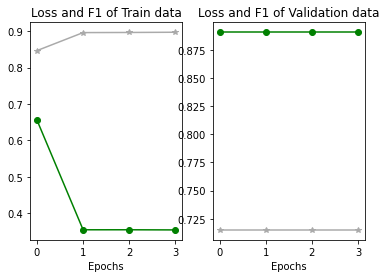

[I 2022-05-31 10:51:42,579] Trial 10 finished with value: 0.7150370599101508 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 4.0210, f1 score : 0.1431
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.0799, f1 score : 0.0550
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.0496, f1 score : 0.1390
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9631, f1 score : 0.0561
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9035, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.9835, f1 score : 0.0176
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.9397, f1 score : 0.0217
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.7978, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0717
Epoch 0 Total Mean f1 : 0.0512
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3044 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8820, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 15.568556785583496초
green is loss, gray is f1


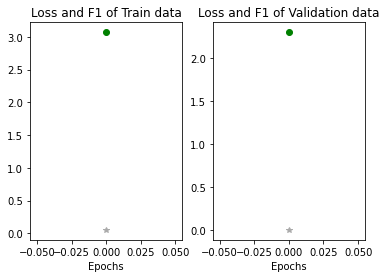

[I 2022-05-31 10:55:15,131] Trial 11 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0009401473, Avg Loss : 4.4922, f1 score : 0.1895
Epoch: 0, Step : 128, LR : 0.0008812155, Avg Loss : 3.2425, f1 score : 0.1300
Epoch: 0, Step : 192, LR : 0.0008222836, Avg Loss : 3.0225, f1 score : 0.0820
Epoch: 0, Step : 256, LR : 0.0007633517, Avg Loss : 3.4632, f1 score : 0.1459
Epoch: 0, Step : 320, LR : 0.0007044199, Avg Loss : 3.0934, f1 score : 0.0793
Epoch: 0, Step : 384, LR : 0.0006454880, Avg Loss : 3.0780, f1 score : 0.1119
Epoch: 0, Step : 448, LR : 0.0005865562, Avg Loss : 3.1584, f1 score : 0.0345
Epoch: 0, Step : 512, LR : 0.0005276243, Avg Loss : 3.1747, f1 score : 0.0493
Epoch: 0, Step : 576, LR : 0.0004686924, Avg Loss : 3.1954, f1 score : 0.0681
Epoch: 0, Step : 640, LR : 0.0004097606, Avg Loss : 2.9064, f1 score : 0.0070
Epoch: 0, Step : 704, LR : 0.0003508287, Avg Loss : 2.9158, f1 score : 0.0000
E

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3042 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000e+00, -4.5115e-04],
        [-4.5115e-04,  1.0000e+00]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7446, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 10.151418209075928초
green is loss, gray is f1


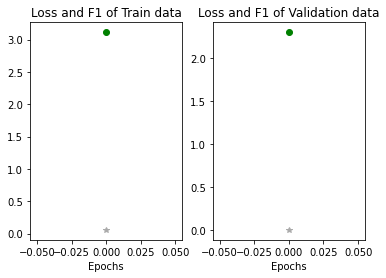

[I 2022-05-31 10:58:42,262] Trial 12 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.4046, f1 score : 0.0404
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 2.9120, f1 score : 0.0367
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.0043, f1 score : 0.0765
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.8499, f1 score : 0.0295
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.8980, f1 score : 0.0092
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.9341, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.9293, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.7943, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9535
Epoch 0 Total Mean f1 : 0.0227
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3046 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7782, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 14.554088354110718초
green is loss, gray is f1


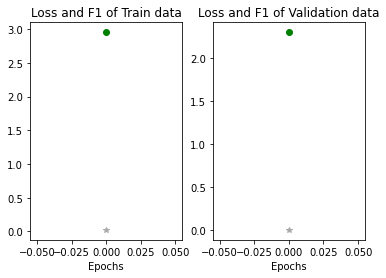

[I 2022-05-31 11:02:13,783] Trial 13 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.5035, f1 score : 0.1100
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.0395, f1 score : 0.0416
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.1504, f1 score : 0.0814
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 3.0465, f1 score : 0.0712
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.8468, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8647, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8518, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8637, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0128
Epoch 0 Total Mean f1 : 0.0361
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3407 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0353],
        [-0.0353,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8035, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 14.07100510597229초
green is loss, gray is f1


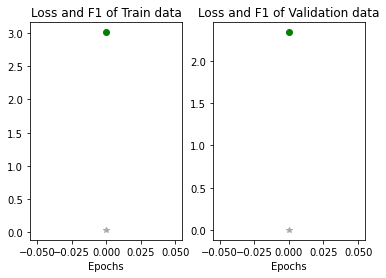

[I 2022-05-31 11:05:44,899] Trial 14 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : klue/bert-base, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000470074, Avg Loss : 1.5101, f1 score : 0.7206
Epoch: 0, Step : 128, LR : 0.0000440608, Avg Loss : 0.7347, f1 score : 0.8494
Epoch: 0, Step : 192, LR : 0.0000411142, Avg Loss : 0.7465, f1 score : 0.8163
Epoch: 0, Step : 256, LR : 0.0000381676, Avg Loss : 0.6789, f1 score : 0.8461
Epoch: 0, Step : 320, LR : 0.0000352210, Avg Loss : 0.6489, f1 score : 0.8545
Epoch: 0, Step : 384, LR : 0.0000322744, Avg Loss : 0.6513, f1 score : 0.8590
Epoch: 0, Step : 448, LR : 0.0000293278, Avg Loss : 0.6448, f1 score : 0.8410
Epoch: 0, Step : 512, LR : 0.0000263812, Avg Loss : 0.5575, f1 score : 0.8504
Epoch: 0, Step : 576, LR : 0.0000234346, Avg Loss : 0.5946, f1 score : 0.8202
Epoch: 0, Step : 640, LR : 0.0000204880, Avg Loss : 0.5843, f1 score : 0.8490
Epoch: 0, Step : 704, LR : 0.0000175414, Avg Loss : 0.5967, f1 score : 0.8782
Ep

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.8895 Valid Acc : 0.7751 Valid f1 : 0.7254
pearson 상관 계수 ; tensor([[1.0000, 0.7428],
        [0.7428, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.8895_f1:0.7254.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3035, f1 score : 0.9125
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3615, f1 score : 0.9096
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3310, f1 score : 0.8924
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3401, f1 score : 0.9188
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3152, f1 score : 0.9083
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3103, f1 score : 0.9008
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3078, f1 score : 0.9028
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.2987, f1 score : 0.9147
Epoch: 1, Step : 576, LR : 0.0000000000, Avg Loss : 0.298

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.8895 Valid Acc : 0.7751 Valid f1 : 0.7254
pearson 상관 계수 ; tensor([[1.0000, 0.7428],
        [0.7428, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.2988, f1 score : 0.8833
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.2933, f1 score : 0.9142
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3099, f1 score : 0.9218
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3400, f1 score : 0.9061
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3438, f1 score : 0.9165
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3119, f1 score : 0.9094
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.2768, f1 score : 0.9128
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3213, f1 score : 0.9195
Epoch: 2, Step : 576, LR : 0.0000000000, Avg Loss : 0.3596, f1 score : 0.9040
Epoch: 2, Step : 640, LR : 0.0000000000, Avg Loss : 0.2783, f1 score : 0.9050
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.8895 Valid Acc : 0.7751 Valid f1 : 0.7254
pearson 상관 계수 ; tensor([[1.0000, 0.7428],
        [0.7428, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3396, f1 score : 0.9009
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3161, f1 score : 0.8940
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3724, f1 score : 0.8991
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3153, f1 score : 0.9100
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3366, f1 score : 0.8941
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3457, f1 score : 0.8887
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3460, f1 score : 0.8914
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3115, f1 score : 0.9219
Epoch: 3, Step : 576, LR : 0.0000000000, Avg Loss : 0.3073, f1 score : 0.9091
Epoch: 3, Step : 640, LR : 0.0000000000, Avg Loss : 0.3157, f1 score : 0.9083
Epoch: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.8895 Valid Acc : 0.7751 Valid f1 : 0.7254
pearson 상관 계수 ; tensor([[1.0000, 0.7428],
        [0.7428, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 12.0분 2.564805269241333초
green is loss, gray is f1


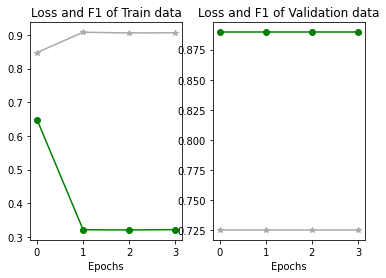

[I 2022-05-31 11:18:04,469] Trial 15 finished with value: 0.7254038767230346 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 3e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000264088, Avg Loss : 1.4429, f1 score : 0.7671
Epoch: 0, Step : 128, LR : 0.0000228729, Avg Loss : 0.6816, f1 score : 0.8586
Epoch: 0, Step : 192, LR : 0.0000193370, Avg Loss : 0.6447, f1 score : 0.8424
Epoch: 0, Step : 256, LR : 0.0000158011, Avg Loss : 0.6209, f1 score : 0.8544
Epoch: 0, Step : 320, LR : 0.0000122652, Avg Loss : 0.5735, f1 score : 0.8604
Epoch: 0, Step : 384, LR : 0.0000087293, Avg Loss : 0.5128, f1 score : 0.8700
Epoch: 0, Step : 448, LR : 0.0000051934, Avg Loss : 0.5728, f1 score : 0.8604
Epoch: 0, Step : 512, LR : 0.0000016575, Avg Loss : 0.5443, f1 score : 0.8589
Epoch 0 Total Mean Loss : 0.6876
Epoch 0 Total Mean f1 : 0.8481
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.8998 Valid Acc : 0.7730 Valid f1 : 0.7168
pearson 상관 계수 ; tensor([[1.0000, 0.7382],
        [0.7382, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.8998_f1:0.7168.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3944, f1 score : 0.8952
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.4135, f1 score : 0.8967
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3984, f1 score : 0.8828
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3767, f1 score : 0.8998
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3930, f1 score : 0.8927
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.4281, f1 score : 0.8892
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3846, f1 score : 0.8939
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.4037, f1 score : 0.8942
Epoch 1 Total Mean Loss : 0.3959
Epoch 1 Total Mean f1 : 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.8998 Valid Acc : 0.7730 Valid f1 : 0.7168
pearson 상관 계수 ; tensor([[1.0000, 0.7382],
        [0.7382, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3666, f1 score : 0.9068
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3775, f1 score : 0.8908
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.4239, f1 score : 0.8864
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3732, f1 score : 0.8954
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.4078, f1 score : 0.8966
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3943, f1 score : 0.8964
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.4207, f1 score : 0.9010
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3727, f1 score : 0.8978
Epoch 2 Total Mean Loss : 0.3916
Epoch 2 Total Mean f1 : 0.8968
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.8998 Valid Acc : 0.7730 Valid f1 : 0.7168
pearson 상관 계수 ; tensor([[1.0000, 0.7382],
        [0.7382, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3784, f1 score : 0.8932
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3890, f1 score : 0.9036
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.4123, f1 score : 0.9030
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3919, f1 score : 0.8927
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3918, f1 score : 0.8966
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3813, f1 score : 0.9019
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3902, f1 score : 0.8936
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.4219, f1 score : 0.8754
Epoch 3 Total Mean Loss : 0.3952
Epoch 3 Total Mean f1 : 0.8953
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.8998 Valid Acc : 0.7730 Valid f1 : 0.7168
pearson 상관 계수 ; tensor([[1.0000, 0.7382],
        [0.7382, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 42.88525438308716초
green is loss, gray is f1


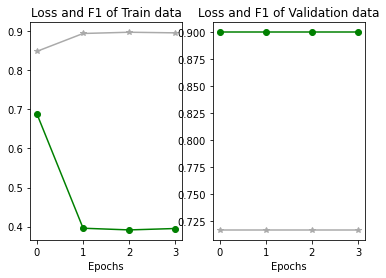

[I 2022-05-31 11:30:04,313] Trial 16 finished with value: 0.716823039657431 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.5478, f1 score : 0.0803
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 2.8819, f1 score : 0.0324
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.0522, f1 score : 0.0824
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 3.0220, f1 score : 0.0999
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9614, f1 score : 0.0197
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8761, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8159, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8953, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0029
Epoch 0 Total Mean f1 : 0.0372
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3106 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7850, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 15.191274642944336초
green is loss, gray is f1


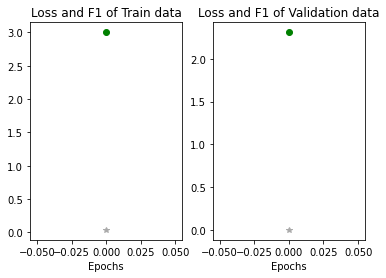

[I 2022-05-31 11:33:36,677] Trial 17 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.7760, f1 score : 0.1474
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.1455, f1 score : 0.1083
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.1162, f1 score : 0.0401
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9734, f1 score : 0.0279
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9453, f1 score : 0.1309
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8779, f1 score : 0.0206
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8926, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8275, f1 score : 0.0052
Epoch 0 Total Mean Loss : 3.0559
Epoch 0 Total Mean f1 : 0.0569
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3112 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.9097, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 16.018932104110718초
green is loss, gray is f1


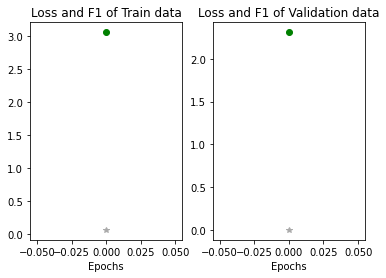

[I 2022-05-31 11:37:09,976] Trial 18 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.3911, f1 score : 0.0515
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 2.8949, f1 score : 0.0100
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 2.9988, f1 score : 0.0207
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.8167, f1 score : 0.0202
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.8850, f1 score : 0.0250
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.9437, f1 score : 0.0217
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8741, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8122, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9463
Epoch 0 Total Mean f1 : 0.0177
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3061 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0520],
        [0.0520, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8272, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 15.073172569274902초
green is loss, gray is f1


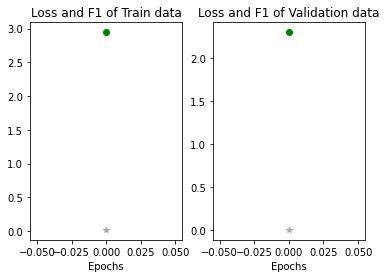

[I 2022-05-31 11:40:42,126] Trial 19 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 2e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000176059, Avg Loss : 1.6149, f1 score : 0.7891
Epoch: 0, Step : 128, LR : 0.0000152486, Avg Loss : 0.6639, f1 score : 0.8293
Epoch: 0, Step : 192, LR : 0.0000128913, Avg Loss : 0.6192, f1 score : 0.8519
Epoch: 0, Step : 256, LR : 0.0000105341, Avg Loss : 0.6200, f1 score : 0.8520
Epoch: 0, Step : 320, LR : 0.0000081768, Avg Loss : 0.5573, f1 score : 0.8569
Epoch: 0, Step : 384, LR : 0.0000058195, Avg Loss : 0.5822, f1 score : 0.8654
Epoch: 0, Step : 448, LR : 0.0000034622, Avg Loss : 0.5778, f1 score : 0.8496
Epoch: 0, Step : 512, LR : 0.0000011050, Avg Loss : 0.5522, f1 score : 0.8826
Epoch 0 Total Mean Loss : 0.7198
Epoch 0 Total Mean f1 : 0.8485
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.9353 Valid Acc : 0.7618 Valid f1 : 0.7224
pearson 상관 계수 ; tensor([[1.0000, 0.7274],
        [0.7274, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.9353_f1:0.7224.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.4266, f1 score : 0.8787
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.4272, f1 score : 0.8992
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.4284, f1 score : 0.8961
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.4764, f1 score : 0.8812
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.4512, f1 score : 0.8784
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.4125, f1 score : 0.8766
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.4734, f1 score : 0.8911
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.4327, f1 score : 0.8832
Epoch 1 Total Mean Loss : 0.4422
Epoch 1 Total Mean f1 : 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.9353 Valid Acc : 0.7618 Valid f1 : 0.7224
pearson 상관 계수 ; tensor([[1.0000, 0.7274],
        [0.7274, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.4545, f1 score : 0.8858
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.4606, f1 score : 0.8751
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.4465, f1 score : 0.8908
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.4296, f1 score : 0.8866
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.4203, f1 score : 0.8951
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.4644, f1 score : 0.8918
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.4343, f1 score : 0.8811
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.4438, f1 score : 0.8834
Epoch 2 Total Mean Loss : 0.4449
Epoch 2 Total Mean f1 : 0.8863
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.9353 Valid Acc : 0.7618 Valid f1 : 0.7224
pearson 상관 계수 ; tensor([[1.0000, 0.7274],
        [0.7274, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.4285, f1 score : 0.8835
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.4558, f1 score : 0.8887
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.4042, f1 score : 0.8994
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.4502, f1 score : 0.8797
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.4595, f1 score : 0.8942
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.4424, f1 score : 0.8840
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.4514, f1 score : 0.8878
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.4409, f1 score : 0.8900
Epoch 3 Total Mean Loss : 0.4421
Epoch 3 Total Mean f1 : 0.8874
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.9353 Valid Acc : 0.7618 Valid f1 : 0.7224
pearson 상관 계수 ; tensor([[1.0000, 0.7274],
        [0.7274, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 42.66447997093201초
green is loss, gray is f1


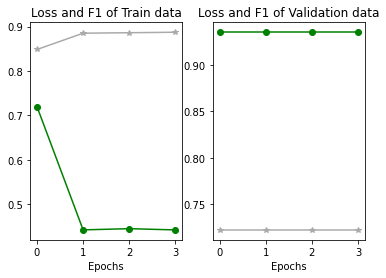

[I 2022-05-31 11:52:41,807] Trial 20 finished with value: 0.7223737447599438 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 2e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.4623, f1 score : 0.1371
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.0192, f1 score : 0.0489
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 2.8981, f1 score : 0.0516
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9259, f1 score : 0.0413
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9556, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.9511, f1 score : 0.0337
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8818, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8351, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9837
Epoch 0 Total Mean f1 : 0.0371
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3587 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0270],
        [0.0270, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8493, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 14.519942283630371초
green is loss, gray is f1


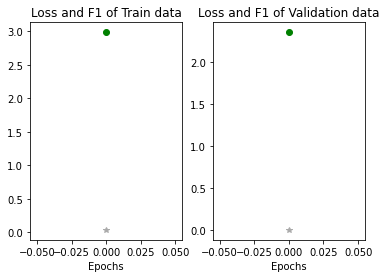

[I 2022-05-31 11:56:13,353] Trial 21 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.4905, f1 score : 0.1351
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.0938, f1 score : 0.0412
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 2.9243, f1 score : 0.0352
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 3.0932, f1 score : 0.1128
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9368, f1 score : 0.0033
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8184, f1 score : 0.0265
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8167, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8814, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9981
Epoch 0 Total Mean f1 : 0.0420
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3225 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8935, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 15.786446332931519초
green is loss, gray is f1


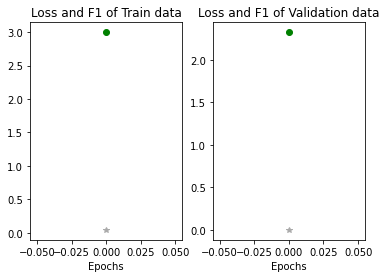

[I 2022-05-31 11:59:46,152] Trial 22 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.4195, f1 score : 0.1090
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 2.9262, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 2.8387, f1 score : 0.0611
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 3.0051, f1 score : 0.0071
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.8891, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.9301, f1 score : 0.0271
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.9628, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8513, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9703
Epoch 0 Total Mean f1 : 0.0243
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3135 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8754, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 15.778316736221313초
green is loss, gray is f1


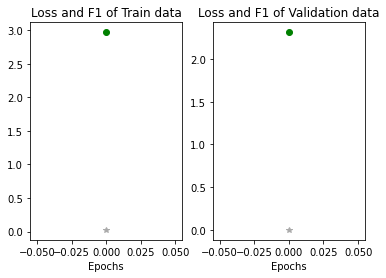

[I 2022-05-31 12:03:18,904] Trial 23 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.6305, f1 score : 0.1618
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 2.9427, f1 score : 0.1263
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.0572, f1 score : 0.0592
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9326, f1 score : 0.0193
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9110, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.9286, f1 score : 0.0389
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.9060, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.8486, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0093
Epoch 0 Total Mean f1 : 0.0481
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3147 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8179, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 15.971675634384155초
green is loss, gray is f1


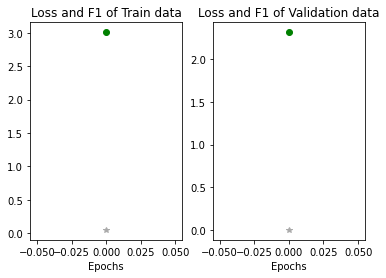

[I 2022-05-31 12:06:51,957] Trial 24 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000440147, Avg Loss : 1.2614, f1 score : 0.7989
Epoch: 0, Step : 128, LR : 0.0000381215, Avg Loss : 0.6677, f1 score : 0.8570
Epoch: 0, Step : 192, LR : 0.0000322284, Avg Loss : 0.6091, f1 score : 0.8461
Epoch: 0, Step : 256, LR : 0.0000263352, Avg Loss : 0.5783, f1 score : 0.8567
Epoch: 0, Step : 320, LR : 0.0000204420, Avg Loss : 0.5564, f1 score : 0.8589
Epoch: 0, Step : 384, LR : 0.0000145488, Avg Loss : 0.5716, f1 score : 0.8530
Epoch: 0, Step : 448, LR : 0.0000086556, Avg Loss : 0.5158, f1 score : 0.8813
Epoch: 0, Step : 512, LR : 0.0000027624, Avg Loss : 0.5417, f1 score : 0.8738
Epoch 0 Total Mean Loss : 0.6566
Epoch 0 Total Mean f1 : 0.8544
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.9014 Valid Acc : 0.7683 Valid f1 : 0.7057
pearson 상관 계수 ; tensor([[1.0000, 0.7385],
        [0.7385, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.9014_f1:0.7057.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3592, f1 score : 0.9023
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3486, f1 score : 0.8981
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3263, f1 score : 0.9200
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3404, f1 score : 0.8987
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3404, f1 score : 0.8972
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3471, f1 score : 0.9084
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3517, f1 score : 0.9096
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3724, f1 score : 0.8972
Epoch 1 Total Mean Loss : 0.3455
Epoch 1 Total Mean f1 : 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.9014 Valid Acc : 0.7683 Valid f1 : 0.7057
pearson 상관 계수 ; tensor([[1.0000, 0.7385],
        [0.7385, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3562, f1 score : 0.8920
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3388, f1 score : 0.9059
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3322, f1 score : 0.9024
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3399, f1 score : 0.9181
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3430, f1 score : 0.9019
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3478, f1 score : 0.9169
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.3538, f1 score : 0.9069
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3559, f1 score : 0.9006
Epoch 2 Total Mean Loss : 0.3447
Epoch 2 Total Mean f1 : 0.9044
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.9014 Valid Acc : 0.7683 Valid f1 : 0.7057
pearson 상관 계수 ; tensor([[1.0000, 0.7385],
        [0.7385, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3449, f1 score : 0.9043
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3499, f1 score : 0.9049
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3148, f1 score : 0.9082
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3373, f1 score : 0.9002
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3611, f1 score : 0.9077
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3629, f1 score : 0.8953
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3338, f1 score : 0.9102
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3501, f1 score : 0.9058
Epoch 3 Total Mean Loss : 0.3450
Epoch 3 Total Mean f1 : 0.9035
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.9014 Valid Acc : 0.7683 Valid f1 : 0.7057
pearson 상관 계수 ; tensor([[1.0000, 0.7385],
        [0.7385, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 11.0분 45.01518535614014초
green is loss, gray is f1


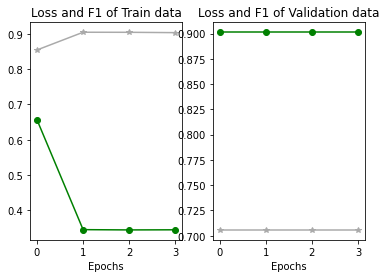

[I 2022-05-31 12:18:54,028] Trial 25 finished with value: 0.7056897562091646 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : klue/bert-base, lr : 3e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 1.6568, f1 score : 0.7459
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 0.7348, f1 score : 0.8438
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 0.6852, f1 score : 0.8399
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 0.7092, f1 score : 0.8442
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 0.5273, f1 score : 0.8450
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 0.6072, f1 score : 0.8509
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 0.5668, f1 score : 0.8658
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 0.6456, f1 score : 0.8464
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 0.6060, f1 score : 0.8665
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 0.5476, f1 score : 0.8623
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 0.5614, f1 score : 0.8584
Ep

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 0.8751 Valid Acc : 0.7695 Valid f1 : 0.7197
pearson 상관 계수 ; tensor([[1.0000, 0.7443],
        [0.7443, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/epoch:0_loss:0.8751_f1:0.7197.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3707, f1 score : 0.8998
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3595, f1 score : 0.8756
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3428, f1 score : 0.8691
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3730, f1 score : 0.8878
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3382, f1 score : 0.9000
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3588, f1 score : 0.9156
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.2879, f1 score : 0.9292
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3830, f1 score : 0.9019
Epoch: 1, Step : 576, LR : 0.0000000000, Avg Loss : 0.321

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 1 Valid Loss : 0.8751 Valid Acc : 0.7695 Valid f1 : 0.7197
pearson 상관 계수 ; tensor([[1.0000, 0.7443],
        [0.7443, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3391, f1 score : 0.9041
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3190, f1 score : 0.9183
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3664, f1 score : 0.9029
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3448, f1 score : 0.9000
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3319, f1 score : 0.8976
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3483, f1 score : 0.8983
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.3414, f1 score : 0.9114
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3980, f1 score : 0.8964
Epoch: 2, Step : 576, LR : 0.0000000000, Avg Loss : 0.3691, f1 score : 0.9225
Epoch: 2, Step : 640, LR : 0.0000000000, Avg Loss : 0.3616, f1 score : 0.9049
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 2 Valid Loss : 0.8751 Valid Acc : 0.7695 Valid f1 : 0.7197
pearson 상관 계수 ; tensor([[1.0000, 0.7443],
        [0.7443, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3450, f1 score : 0.9120
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3520, f1 score : 0.9054
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3311, f1 score : 0.9041
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3161, f1 score : 0.9162
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3473, f1 score : 0.9133
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3859, f1 score : 0.8799
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3332, f1 score : 0.9076
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3710, f1 score : 0.8990
Epoch: 3, Step : 576, LR : 0.0000000000, Avg Loss : 0.3314, f1 score : 0.9093
Epoch: 3, Step : 640, LR : 0.0000000000, Avg Loss : 0.3665, f1 score : 0.9038
Epoch: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 3 Valid Loss : 0.8751 Valid Acc : 0.7695 Valid f1 : 0.7197
pearson 상관 계수 ; tensor([[1.0000, 0.7443],
        [0.7443, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 12.0분 6.079844951629639초
green is loss, gray is f1


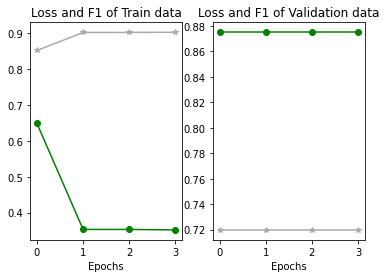

[I 2022-05-31 12:31:17,142] Trial 26 finished with value: 0.7197106962300731 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.5158, f1 score : 0.1153
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.1096, f1 score : 0.0506
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 2.9996, f1 score : 0.0268
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9283, f1 score : 0.0223
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9668, f1 score : 0.0874
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.9449, f1 score : 0.0298
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8898, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.7539, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0080
Epoch 0 Total Mean f1 : 0.0394
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3049 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7548, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 14.794897556304932초
green is loss, gray is f1


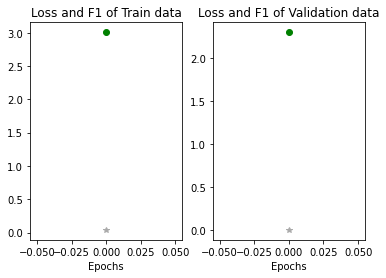

[I 2022-05-31 12:34:49,008] Trial 27 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 4.1076, f1 score : 0.1727
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.3539, f1 score : 0.1158
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.1424, f1 score : 0.1285
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 3.1065, f1 score : 0.0943
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9255, f1 score : 0.0248
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8663, f1 score : 0.0869
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8739, f1 score : 0.0487
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.9017, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.1429
Epoch 0 Total Mean f1 : 0.0795
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3058 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[1.0000, 0.0109],
        [0.0109, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7913, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 14.46976089477539초
green is loss, gray is f1


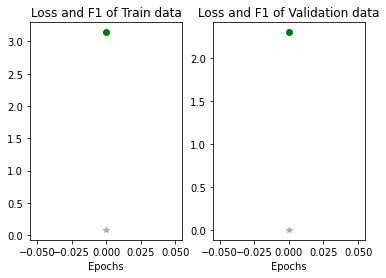

[I 2022-05-31 12:38:20,506] Trial 28 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : klue/bert-base, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.7369, f1 score : 0.2081
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.0707, f1 score : 0.0777
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.0752, f1 score : 0.0961
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9783, f1 score : 0.1245
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9142, f1 score : 0.0380
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8947, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.9003, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.7763, f1 score : 0.0000
Epoch 0 Total Mean Loss : 3.0316
Epoch 0 Total Mean f1 : 0.0646
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch 0 Valid Loss : 2.3071 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[ 1.0000, -0.0010],
        [-0.0010,  1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7419, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 15.665588140487671초
green is loss, gray is f1


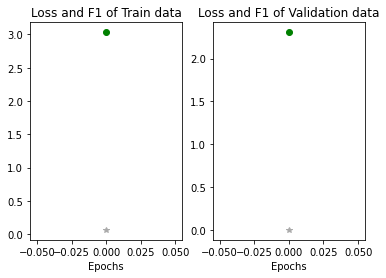

[I 2022-05-31 12:41:53,292] Trial 29 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


0.0
{'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}
[FrozenTrial(number=0, values=[0.0], datetime_start=datetime.datetime(2022, 5, 31, 9, 7, 23, 228807), datetime_complete=datetime.datetime(2022, 5, 31, 9, 10, 57, 648952), params={'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}, distributions={'per_device_train_batch_size': CategoricalDistribution(choices=(16, 32, 64)), 'learning_rate': CategoricalDistribution(choices=(5e-05, 3e-05, 2e-05, 1e-06, 0.001)), 'weight_decay': CategoricalDistribution(choices=(4e-05, 0.01))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None), FrozenTrial(number=1, values=[0.6599229701766901], datetime_start=datetime.datetime(2022, 5, 31, 9, 10, 57, 653200), datetime_complete=datetime.datetime(2022, 5, 31, 9, 22, 20, 698377), params={'per_device_train_batch_size': 64, 'learning_rate': 1e-06,

<Figure size 432x288 with 0 Axes>

In [30]:
print('klue/bert-base\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search') 
study.optimize(objective, n_trials=30)
print(study.best_trial.value) 
print(study.best_params) 
print(study.trials)
optuna.visualization.plot_edf(study)

### snunlp/KR-Medium
- train_batch_size = [16, 32, 64]
- valid_batch_size = 32
- learning_rate = [5e-5, 3e-5, 2e-5, 1e-6, 1e-3, 0.01]
- weight_decay = [4e-5, 0.01]

1. 64, 32, 0.01, 0.01 -> 0.0
2. 16, 32, 5e-05, 0.01 -> 0.7158
3. 64, 32, 3e-05, 0.01 -> 0.7121
4. 16, 32, 0.0001, 0.01 -> 0.7171
5. 16, 32, 3e-05, 0.01 -> 0.7160
6. 64, 32, 0.01, 0.01 -> 0.0
7. 32, 32, 0.0001, 0.01 -> 0.7129
8. 16, 32, 2e-05, 0.01 -> 0.7020
9. 16, 32, 0.001, 0.01 -> 0.0
10. 16, 32, 0.001, 0.01 -> 0.0
11. 64, 32, 0.01, 0.01 -> 0.0
12. 64, 32, 0.01, 0.01 -> 0.0
13. 64, 32, 0.01, 0.01 -> 0.0
14. 64, 32, 0.01, 0.01 -> 0.0
15. 32, 32, 0.01, 0.01 -> 0.0
16. 64, 32, 5e-05, 0.01 -> 0.6965
17. 64, 32, 2e-05, 0.01 -> 0.7157
18. 32, 32, 0.01, 0.01 -> 0.0
19. 32, 32, 0.01, 0.01 -> 0.0
20. 32, 32, 0.01, 0.01 -> 0.5916


[I 2022-05-31 05:27:35,260] A new study created in memory with name: hyper-parameter-search


snunlp/KR-Medium


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0076102941, Avg Loss : 8.3894, f1 score : 0.0147
Epoch: 0, Step : 128, LR : 0.0052573529, Avg Loss : 8.4251, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0029044118, Avg Loss : 8.3392, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0005514706, Avg Loss : 8.5790, f1 score : 0.0000
Epoch 0 Total Mean Loss : 8.4534
Epoch 0 Total Mean f1 : 0.0035
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 8.3324 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 8.4412, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 2.0분 57.84039521217346초
green is loss, gray is f1


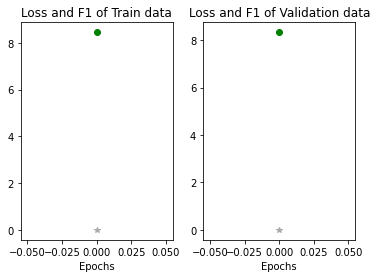

[I 2022-05-31 05:30:51,222] Trial 0 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : snunlp/KR-Medium, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000470074, Avg Loss : 1.4335, f1 score : 0.7502
Epoch: 0, Step : 128, LR : 0.0000440608, Avg Loss : 0.7870, f1 score : 0.8140
Epoch: 0, Step : 192, LR : 0.0000411142, Avg Loss : 0.7427, f1 score : 0.8408
Epoch: 0, Step : 256, LR : 0.0000381676, Avg Loss : 0.6789, f1 score : 0.8505
Epoch: 0, Step : 320, LR : 0.0000352210, Avg Loss : 0.6257, f1 score : 0.8424
Epoch: 0, Step : 384, LR : 0.0000322744, Avg Loss : 0.6230, f1 score : 0.8624
Epoch: 0, Step : 448, LR : 0.0000293278, Avg Loss : 0.5661, f1 score : 0.8782
Epoch: 0, Step : 512, LR : 0.0000263812, Avg Loss : 0.5885, f1 score : 0.8558
Epoch: 0, Step : 576, LR : 0.0000234346, Avg Loss : 0.5343, f1 score : 0.8417
Epoch: 0, Step : 640, LR : 0.0000204880, Avg Loss : 0.5961, f1 score : 0.8591
Epoch: 0, Step : 704, LR : 0.0000175414, Avg Loss : 0.6163, f1 score : 0.8426


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 0.9078 Valid Acc : 0.7692 Valid f1 : 0.7158
pearson 상관 계수 ; tensor([[1.0000, 0.7316],
        [0.7316, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3209, f1 score : 0.9069
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.2987, f1 score : 0.9032
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.2912, f1 score : 0.9126
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3131, f1 score : 0.9118
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3329, f1 score : 0.9000
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3219, f1 score : 0.9012
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3791, f1 score : 0.8752
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3371, f1 score : 0.9106
Epoch: 1, Step : 576, LR : 0.0000000000, Avg Loss : 0.3291, f1 score : 0.9079
Epoch: 1, Step : 640, LR : 0.0000000000, Avg Loss : 0.3031, f1 score : 0.9102
Epoch: 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 0.9078 Valid Acc : 0.7692 Valid f1 : 0.7158
pearson 상관 계수 ; tensor([[1.0000, 0.7316],
        [0.7316, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3581, f1 score : 0.9095
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3480, f1 score : 0.9078
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3223, f1 score : 0.9112
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3112, f1 score : 0.9036
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3255, f1 score : 0.9020
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3204, f1 score : 0.9030
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.3208, f1 score : 0.9137
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3439, f1 score : 0.9039
Epoch: 2, Step : 576, LR : 0.0000000000, Avg Loss : 0.3410, f1 score : 0.8967
Epoch: 2, Step : 640, LR : 0.0000000000, Avg Loss : 0.3008, f1 score : 0.9123
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 0.9078 Valid Acc : 0.7692 Valid f1 : 0.7158
pearson 상관 계수 ; tensor([[1.0000, 0.7316],
        [0.7316, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3194, f1 score : 0.9062
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3429, f1 score : 0.9152
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3501, f1 score : 0.8984
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3136, f1 score : 0.9094
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3388, f1 score : 0.9037
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3303, f1 score : 0.8872
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3484, f1 score : 0.8945
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3465, f1 score : 0.8861
Epoch: 3, Step : 576, LR : 0.0000000000, Avg Loss : 0.3328, f1 score : 0.9256
Epoch: 3, Step : 640, LR : 0.0000000000, Avg Loss : 0.3138, f1 score : 0.9043
Epoch: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



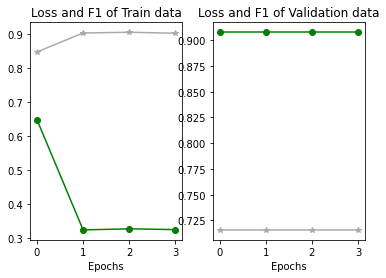

[I 2022-05-31 05:41:35,843] Trial 1 finished with value: 0.7157922481881837 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 5e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 3e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000228309, Avg Loss : 1.4026, f1 score : 0.7866
Epoch: 0, Step : 128, LR : 0.0000157721, Avg Loss : 0.6691, f1 score : 0.8570
Epoch: 0, Step : 192, LR : 0.0000087132, Avg Loss : 0.5756, f1 score : 0.8578
Epoch: 0, Step : 256, LR : 0.0000016544, Avg Loss : 0.5317, f1 score : 0.8695
Epoch 0 Total Mean Loss : 0.7837
Epoch 0 Total Mean f1 : 0.8432
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 1.0047 Valid Acc : 0.7494 Valid f1 : 0.7121
pearson 상관 계수 ; tensor([[1.0000, 0.7089],
        [0.7089, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.4190, f1 score : 0.8913
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.4498, f1 score : 0.8776
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.4512, f1 score : 0.8908
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.4402, f1 score : 0.8918
Epoch 1 Total Mean Loss : 0.4387
Epoch 1 Total Mean f1 : 0.8878
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 1.0047 Valid Acc : 0.7494 Valid f1 : 0.7121
pearson 상관 계수 ; tensor([[1.0000, 0.7089],
        [0.7089, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.4454, f1 score : 0.8862
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.4528, f1 score : 0.8843
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.4115, f1 score : 0.8942
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.4392, f1 score : 0.8876
Epoch 2 Total Mean Loss : 0.4376
Epoch 2 Total Mean f1 : 0.8875
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 1.0047 Valid Acc : 0.7494 Valid f1 : 0.7121
pearson 상관 계수 ; tensor([[1.0000, 0.7089],
        [0.7089, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.4367, f1 score : 0.8838
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.4411, f1 score : 0.8949
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.4325, f1 score : 0.8920
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.4434, f1 score : 0.8829
Epoch 3 Total Mean Loss : 0.4388
Epoch 3 Total Mean f1 : 0.8887
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****
Epoch 3 Valid Loss : 1.0047 Valid Acc : 0.7494 Valid f1 : 0.7121
pearson 상관 계수 ; tensor([[1.0000, 0.7089],
        [0.7089, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 9.0분 39.54548478126526초
green is loss, gray is f1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



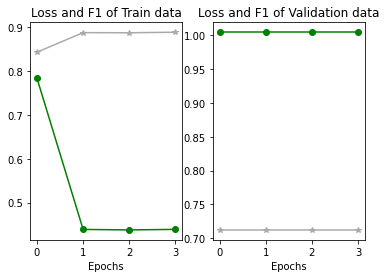

[I 2022-05-31 05:51:33,604] Trial 2 finished with value: 0.7121269313624933 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 3e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : snunlp/KR-Medium, lr : 0.0001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000940147, Avg Loss : 3.0801, f1 score : 0.2536
Epoch: 0, Step : 128, LR : 0.0000881215, Avg Loss : 0.8504, f1 score : 0.8403
Epoch: 0, Step : 192, LR : 0.0000822284, Avg Loss : 0.8685, f1 score : 0.8034
Epoch: 0, Step : 256, LR : 0.0000763352, Avg Loss : 0.7433, f1 score : 0.8262
Epoch: 0, Step : 320, LR : 0.0000704420, Avg Loss : 0.7077, f1 score : 0.8382
Epoch: 0, Step : 384, LR : 0.0000645488, Avg Loss : 0.6972, f1 score : 0.8454
Epoch: 0, Step : 448, LR : 0.0000586556, Avg Loss : 0.6800, f1 score : 0.8283
Epoch: 0, Step : 512, LR : 0.0000527624, Avg Loss : 0.6764, f1 score : 0.8408
Epoch: 0, Step : 576, LR : 0.0000468692, Avg Loss : 0.6190, f1 score : 0.8478
Epoch: 0, Step : 640, LR : 0.0000409761, Avg Loss : 0.5730, f1 score : 0.8696
Epoch: 0, Step : 704, LR : 0.0000350829, Avg Loss : 0.6188, f1 score : 0.8543

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 0.9170 Valid Acc : 0.7686 Valid f1 : 0.7171
pearson 상관 계수 ; tensor([[1.0000, 0.7276],
        [0.7276, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3551, f1 score : 0.9187
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3492, f1 score : 0.8928
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3416, f1 score : 0.9155
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3324, f1 score : 0.8982
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3329, f1 score : 0.8974
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3384, f1 score : 0.8797
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3241, f1 score : 0.9102
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3812, f1 score : 0.8939
Epoch: 1, Step : 576, LR : 0.0000000000, Avg Loss : 0.3430, f1 score : 0.9007
Epoch: 1, Step : 640, LR : 0.0000000000, Avg Loss : 0.3314, f1 score : 0.9098
Epoch: 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 0.9170 Valid Acc : 0.7686 Valid f1 : 0.7171
pearson 상관 계수 ; tensor([[1.0000, 0.7276],
        [0.7276, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3547, f1 score : 0.9091
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.2969, f1 score : 0.9214
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3279, f1 score : 0.9010
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3386, f1 score : 0.9013
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3393, f1 score : 0.8974
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3567, f1 score : 0.8905
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.3237, f1 score : 0.9021
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3463, f1 score : 0.8966
Epoch: 2, Step : 576, LR : 0.0000000000, Avg Loss : 0.3231, f1 score : 0.9070
Epoch: 2, Step : 640, LR : 0.0000000000, Avg Loss : 0.4112, f1 score : 0.8901
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 0.9170 Valid Acc : 0.7686 Valid f1 : 0.7171
pearson 상관 계수 ; tensor([[1.0000, 0.7276],
        [0.7276, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3212, f1 score : 0.8980
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3517, f1 score : 0.8850
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3534, f1 score : 0.9103
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3255, f1 score : 0.8991
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3160, f1 score : 0.9098
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3741, f1 score : 0.8949
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3177, f1 score : 0.9183
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3351, f1 score : 0.9018
Epoch: 3, Step : 576, LR : 0.0000000000, Avg Loss : 0.3444, f1 score : 0.9112
Epoch: 3, Step : 640, LR : 0.0000000000, Avg Loss : 0.3099, f1 score : 0.9142
Epoch: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3 Valid Loss : 0.9170 Valid Acc : 0.7686 Valid f1 : 0.7171
pearson 상관 계수 ; tensor([[1.0000, 0.7276],
        [0.7276, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 10.0분 34.56287407875061초
green is loss, gray is f1


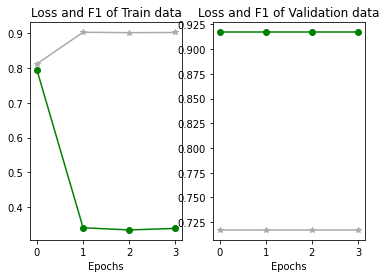

[I 2022-05-31 06:02:26,344] Trial 3 finished with value: 0.7171464437372506 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : snunlp/KR-Medium, lr : 3e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 1.7800, f1 score : 0.7487
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 0.7416, f1 score : 0.8532
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 0.6921, f1 score : 0.8420
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 0.6685, f1 score : 0.8352
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 0.6430, f1 score : 0.8438
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 0.6478, f1 score : 0.8565
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 0.6669, f1 score : 0.8380
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 0.5308, f1 score : 0.8713
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 0.6403, f1 score : 0.8395
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 0.5347, f1 score : 0.8654
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 0.5519, f1 score : 0.8639


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 0.9328 Valid Acc : 0.7642 Valid f1 : 0.7160
pearson 상관 계수 ; tensor([[1.0000, 0.7297],
        [0.7297, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3626, f1 score : 0.9100
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3712, f1 score : 0.8951
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.4007, f1 score : 0.8922
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3693, f1 score : 0.8923
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3309, f1 score : 0.8996
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3099, f1 score : 0.8937
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3591, f1 score : 0.8934
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3586, f1 score : 0.8957
Epoch: 1, Step : 576, LR : 0.0000000000, Avg Loss : 0.3649, f1 score : 0.8685
Epoch: 1, Step : 640, LR : 0.0000000000, Avg Loss : 0.3305, f1 score : 0.8927
Epoch: 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 0.9328 Valid Acc : 0.7642 Valid f1 : 0.7160
pearson 상관 계수 ; tensor([[1.0000, 0.7297],
        [0.7297, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.4297, f1 score : 0.9030
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3540, f1 score : 0.9013
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3646, f1 score : 0.8879
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3325, f1 score : 0.8971
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3478, f1 score : 0.8868
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3699, f1 score : 0.8805
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.3490, f1 score : 0.9020
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3754, f1 score : 0.8934
Epoch: 2, Step : 576, LR : 0.0000000000, Avg Loss : 0.3545, f1 score : 0.8944
Epoch: 2, Step : 640, LR : 0.0000000000, Avg Loss : 0.3195, f1 score : 0.8903
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 0.9328 Valid Acc : 0.7642 Valid f1 : 0.7160
pearson 상관 계수 ; tensor([[1.0000, 0.7297],
        [0.7297, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3624, f1 score : 0.9038
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3397, f1 score : 0.9011
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3872, f1 score : 0.8874
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3690, f1 score : 0.8862
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3424, f1 score : 0.9173
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3410, f1 score : 0.8998
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3578, f1 score : 0.8886
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3534, f1 score : 0.8926
Epoch: 3, Step : 576, LR : 0.0000000000, Avg Loss : 0.3797, f1 score : 0.8944
Epoch: 3, Step : 640, LR : 0.0000000000, Avg Loss : 0.3795, f1 score : 0.8807
Epoch: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3 Valid Loss : 0.9328 Valid Acc : 0.7642 Valid f1 : 0.7160
pearson 상관 계수 ; tensor([[1.0000, 0.7297],
        [0.7297, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 10.0분 33.922956466674805초
green is loss, gray is f1


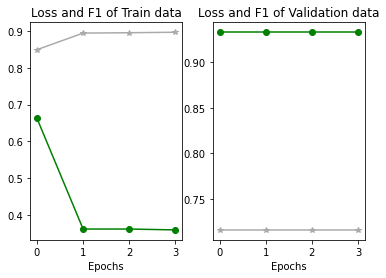

[I 2022-05-31 06:13:18,683] Trial 4 finished with value: 0.7160370022261799 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0076102941, Avg Loss : 8.3837, f1 score : 0.0210
Epoch: 0, Step : 128, LR : 0.0052573529, Avg Loss : 8.5096, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0029044118, Avg Loss : 8.5098, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0005514706, Avg Loss : 8.4644, f1 score : 0.0000
Epoch 0 Total Mean Loss : 8.4539
Epoch 0 Total Mean f1 : 0.0050
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 8.3324 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 8.4480, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 1.1369736194610596초
green is loss, gray is f1


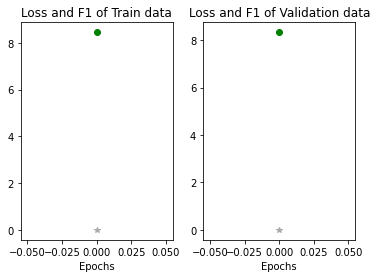

[I 2022-05-31 06:16:38,216] Trial 5 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : snunlp/KR-Medium, lr : 0.0001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000880295, Avg Loss : 1.3652, f1 score : 0.7550
Epoch: 0, Step : 128, LR : 0.0000762431, Avg Loss : 0.7146, f1 score : 0.8357
Epoch: 0, Step : 192, LR : 0.0000644567, Avg Loss : 0.6482, f1 score : 0.8348
Epoch: 0, Step : 256, LR : 0.0000526703, Avg Loss : 0.6411, f1 score : 0.8468
Epoch: 0, Step : 320, LR : 0.0000408840, Avg Loss : 0.5366, f1 score : 0.8676
Epoch: 0, Step : 384, LR : 0.0000290976, Avg Loss : 0.5942, f1 score : 0.8632
Epoch: 0, Step : 448, LR : 0.0000173112, Avg Loss : 0.5356, f1 score : 0.8791
Epoch: 0, Step : 512, LR : 0.0000055249, Avg Loss : 0.4699, f1 score : 0.8770
Epoch 0 Total Mean Loss : 0.6819
Epoch 0 Total Mean f1 : 0.8458
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 0.8816 Valid Acc : 0.7727 Valid f1 : 0.7129
pearson 상관 계수 ; tensor([[1.0000, 0.7404],
        [0.7404, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3341, f1 score : 0.9117
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.2903, f1 score : 0.9141
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3316, f1 score : 0.9006
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3218, f1 score : 0.9121
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.2999, f1 score : 0.9173
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.2965, f1 score : 0.9096
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3345, f1 score : 0.9110
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3255, f1 score : 0.9112
Epoch 1 Total Mean Loss : 0.3162
Epoch 1 Total Mean f1 : 0.9104
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 0.8816 Valid Acc : 0.7727 Valid f1 : 0.7129
pearson 상관 계수 ; tensor([[1.0000, 0.7404],
        [0.7404, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3223, f1 score : 0.9030
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.2911, f1 score : 0.9057
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3308, f1 score : 0.9068
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3286, f1 score : 0.9116
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.3143, f1 score : 0.9066
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.3116, f1 score : 0.9091
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.3143, f1 score : 0.9184
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3287, f1 score : 0.9185
Epoch 2 Total Mean Loss : 0.3164
Epoch 2 Total Mean f1 : 0.9091
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 0.8816 Valid Acc : 0.7727 Valid f1 : 0.7129
pearson 상관 계수 ; tensor([[1.0000, 0.7404],
        [0.7404, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3065, f1 score : 0.9134
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3153, f1 score : 0.9155
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.2915, f1 score : 0.9183
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3171, f1 score : 0.9018
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3117, f1 score : 0.9087
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3160, f1 score : 0.9032
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3321, f1 score : 0.9128
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3151, f1 score : 0.9096
Epoch 3 Total Mean Loss : 0.3150
Epoch 3 Total Mean f1 : 0.9096
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3 Valid Loss : 0.8816 Valid Acc : 0.7727 Valid f1 : 0.7129
pearson 상관 계수 ; tensor([[1.0000, 0.7404],
        [0.7404, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 10.0분 11.511062145233154초
green is loss, gray is f1


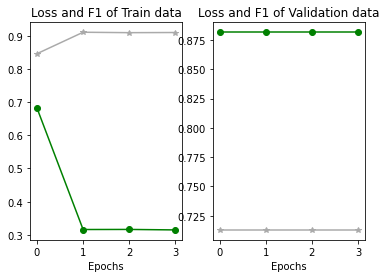

[I 2022-05-31 06:27:08,181] Trial 6 finished with value: 0.7129224076065281 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : snunlp/KR-Medium, lr : 2e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000188029, Avg Loss : 1.9440, f1 score : 0.7445
Epoch: 0, Step : 128, LR : 0.0000176243, Avg Loss : 0.8679, f1 score : 0.7921
Epoch: 0, Step : 192, LR : 0.0000164457, Avg Loss : 0.6592, f1 score : 0.8307
Epoch: 0, Step : 256, LR : 0.0000152670, Avg Loss : 0.6438, f1 score : 0.8570
Epoch: 0, Step : 320, LR : 0.0000140884, Avg Loss : 0.7062, f1 score : 0.8326
Epoch: 0, Step : 384, LR : 0.0000129098, Avg Loss : 0.5750, f1 score : 0.8603
Epoch: 0, Step : 448, LR : 0.0000117311, Avg Loss : 0.5742, f1 score : 0.8736
Epoch: 0, Step : 512, LR : 0.0000105525, Avg Loss : 0.5766, f1 score : 0.8683
Epoch: 0, Step : 576, LR : 0.0000093738, Avg Loss : 0.5950, f1 score : 0.8532
Epoch: 0, Step : 640, LR : 0.0000081952, Avg Loss : 0.5580, f1 score : 0.8712
Epoch: 0, Step : 704, LR : 0.0000070166, Avg Loss : 0.5101, f1 score : 0.8433


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 0.9570 Valid Acc : 0.7538 Valid f1 : 0.7020
pearson 상관 계수 ; tensor([[1.0000, 0.7162],
        [0.7162, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.3914, f1 score : 0.8994
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.4214, f1 score : 0.8829
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.3525, f1 score : 0.8947
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.4057, f1 score : 0.9068
Epoch: 1, Step : 320, LR : 0.0000000000, Avg Loss : 0.3838, f1 score : 0.8824
Epoch: 1, Step : 384, LR : 0.0000000000, Avg Loss : 0.3899, f1 score : 0.8826
Epoch: 1, Step : 448, LR : 0.0000000000, Avg Loss : 0.3546, f1 score : 0.8928
Epoch: 1, Step : 512, LR : 0.0000000000, Avg Loss : 0.3791, f1 score : 0.8745
Epoch: 1, Step : 576, LR : 0.0000000000, Avg Loss : 0.4423, f1 score : 0.8703
Epoch: 1, Step : 640, LR : 0.0000000000, Avg Loss : 0.4061, f1 score : 0.8861
Epoch: 1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 0.9570 Valid Acc : 0.7538 Valid f1 : 0.7020
pearson 상관 계수 ; tensor([[1.0000, 0.7162],
        [0.7162, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3832, f1 score : 0.8852
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3826, f1 score : 0.8832
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.4204, f1 score : 0.8808
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3784, f1 score : 0.8818
Epoch: 2, Step : 320, LR : 0.0000000000, Avg Loss : 0.4012, f1 score : 0.8929
Epoch: 2, Step : 384, LR : 0.0000000000, Avg Loss : 0.4134, f1 score : 0.8825
Epoch: 2, Step : 448, LR : 0.0000000000, Avg Loss : 0.4270, f1 score : 0.8823
Epoch: 2, Step : 512, LR : 0.0000000000, Avg Loss : 0.3683, f1 score : 0.9032
Epoch: 2, Step : 576, LR : 0.0000000000, Avg Loss : 0.4546, f1 score : 0.8854
Epoch: 2, Step : 640, LR : 0.0000000000, Avg Loss : 0.3684, f1 score : 0.8890
Epoch: 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 0.9570 Valid Acc : 0.7538 Valid f1 : 0.7020
pearson 상관 계수 ; tensor([[1.0000, 0.7162],
        [0.7162, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.4277, f1 score : 0.8868
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.3451, f1 score : 0.9083
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.4202, f1 score : 0.8789
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3816, f1 score : 0.8954
Epoch: 3, Step : 320, LR : 0.0000000000, Avg Loss : 0.3968, f1 score : 0.8939
Epoch: 3, Step : 384, LR : 0.0000000000, Avg Loss : 0.3835, f1 score : 0.8994
Epoch: 3, Step : 448, LR : 0.0000000000, Avg Loss : 0.3800, f1 score : 0.8990
Epoch: 3, Step : 512, LR : 0.0000000000, Avg Loss : 0.3719, f1 score : 0.8906
Epoch: 3, Step : 576, LR : 0.0000000000, Avg Loss : 0.4259, f1 score : 0.8782
Epoch: 3, Step : 640, LR : 0.0000000000, Avg Loss : 0.3937, f1 score : 0.8784
Epoch: 3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3 Valid Loss : 0.9570 Valid Acc : 0.7538 Valid f1 : 0.7020
pearson 상관 계수 ; tensor([[1.0000, 0.7162],
        [0.7162, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 10.0분 34.70219826698303초
green is loss, gray is f1


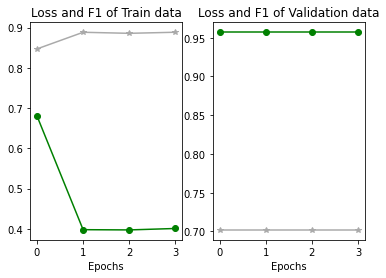

[I 2022-05-31 06:38:01,353] Trial 7 finished with value: 0.7020039018381907 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : snunlp/KR-Medium, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0009401473, Avg Loss : 3.4974, f1 score : 0.1804
Epoch: 0, Step : 128, LR : 0.0008812155, Avg Loss : 3.2854, f1 score : 0.1097
Epoch: 0, Step : 192, LR : 0.0008222836, Avg Loss : 3.2832, f1 score : 0.1900
Epoch: 0, Step : 256, LR : 0.0007633517, Avg Loss : 2.9221, f1 score : 0.0781
Epoch: 0, Step : 320, LR : 0.0007044199, Avg Loss : 3.1527, f1 score : 0.0388
Epoch: 0, Step : 384, LR : 0.0006454880, Avg Loss : 3.1982, f1 score : 0.1467
Epoch: 0, Step : 448, LR : 0.0005865562, Avg Loss : 3.2255, f1 score : 0.1077
Epoch: 0, Step : 512, LR : 0.0005276243, Avg Loss : 3.1351, f1 score : 0.1070
Epoch: 0, Step : 576, LR : 0.0004686924, Avg Loss : 3.0592, f1 score : 0.1042
Epoch: 0, Step : 640, LR : 0.0004097606, Avg Loss : 2.8899, f1 score : 0.0326
Epoch: 0, Step : 704, LR : 0.0003508287, Avg Loss : 3.0055, f1 score : 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3071 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7700, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 2.0분 48.28181219100952초
green is loss, gray is f1


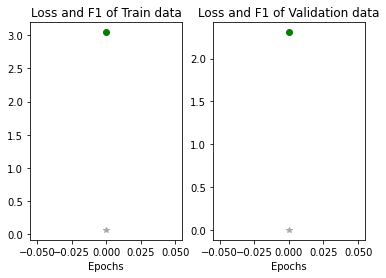

[I 2022-05-31 06:41:08,078] Trial 8 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.001}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 1086
model_name : snunlp/KR-Medium, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0009401473, Avg Loss : 3.4846, f1 score : 0.1561
Epoch: 0, Step : 128, LR : 0.0008812155, Avg Loss : 3.3544, f1 score : 0.1690
Epoch: 0, Step : 192, LR : 0.0008222836, Avg Loss : 3.1000, f1 score : 0.1299
Epoch: 0, Step : 256, LR : 0.0007633517, Avg Loss : 2.9611, f1 score : 0.0211
Epoch: 0, Step : 320, LR : 0.0007044199, Avg Loss : 3.2125, f1 score : 0.1329
Epoch: 0, Step : 384, LR : 0.0006454880, Avg Loss : 2.9974, f1 score : 0.0734
Epoch: 0, Step : 448, LR : 0.0005865562, Avg Loss : 3.1121, f1 score : 0.1024
Epoch: 0, Step : 512, LR : 0.0005276243, Avg Loss : 2.9593, f1 score : 0.0268
Epoch: 0, Step : 576, LR : 0.0004686924, Avg Loss : 2.9919, f1 score : 0.0796
Epoch: 0, Step : 640, LR : 0.0004097606, Avg Loss : 3.0269, f1 score : 0.1145
Epoch: 0, Step : 704, LR : 0.0003508287, Avg Loss : 2.9264, f1 score : 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3254 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8318, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 2.0분 48.341883182525635초
green is loss, gray is f1


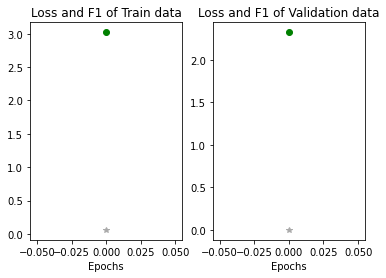

[I 2022-05-31 06:44:14,827] Trial 9 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 0.001}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0076102941, Avg Loss : 8.4065, f1 score : 0.0215
Epoch: 0, Step : 128, LR : 0.0052573529, Avg Loss : 8.3704, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0029044118, Avg Loss : 8.4000, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0005514706, Avg Loss : 8.6880, f1 score : 0.0000
Epoch 0 Total Mean Loss : 8.4551
Epoch 0 Total Mean f1 : 0.0051
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 8.3324 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 8.4237, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 0.5390925407409668초
green is loss, gray is f1


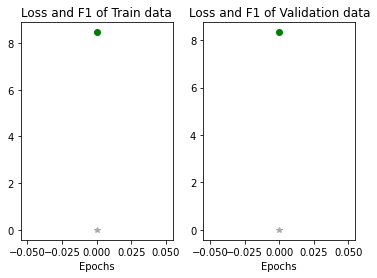

[I 2022-05-31 06:47:33,867] Trial 10 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0076102941, Avg Loss : 8.3791, f1 score : 0.0204
Epoch: 0, Step : 128, LR : 0.0052573529, Avg Loss : 8.4842, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0029044118, Avg Loss : 8.4047, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0005514706, Avg Loss : 8.5557, f1 score : 0.0000
Epoch 0 Total Mean Loss : 8.4592
Epoch 0 Total Mean f1 : 0.0049
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 8.3324 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 8.1682, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 0.4507169723510742초
green is loss, gray is f1


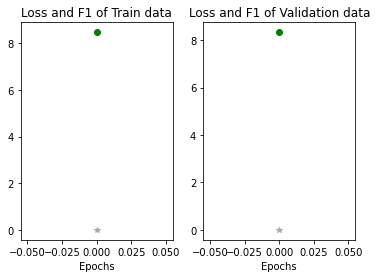

[I 2022-05-31 06:50:52,702] Trial 11 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0076102941, Avg Loss : 5.5570, f1 score : 0.2597
Epoch: 0, Step : 128, LR : 0.0052573529, Avg Loss : 4.7388, f1 score : 0.2505
Epoch: 0, Step : 192, LR : 0.0029044118, Avg Loss : 4.3656, f1 score : 0.2382
Epoch: 0, Step : 256, LR : 0.0005514706, Avg Loss : 3.2279, f1 score : 0.0726
Epoch 0 Total Mean Loss : 4.3793
Epoch 0 Total Mean f1 : 0.1941
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3077 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8619, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 0.5524890422821045초
green is loss, gray is f1


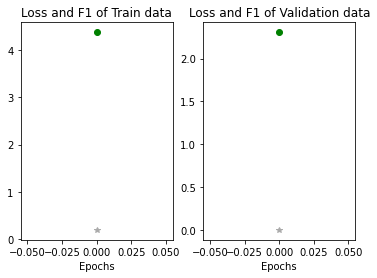

[I 2022-05-31 06:54:11,719] Trial 12 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0076102941, Avg Loss : 8.4942, f1 score : 0.0214
Epoch: 0, Step : 128, LR : 0.0052573529, Avg Loss : 8.5311, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0029044118, Avg Loss : 8.5444, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0005514706, Avg Loss : 8.2067, f1 score : 0.0000
Epoch 0 Total Mean Loss : 8.4499
Epoch 0 Total Mean f1 : 0.0051
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 8.3324 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 8.5613, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 3.0분 0.6033065319061279초
green is loss, gray is f1


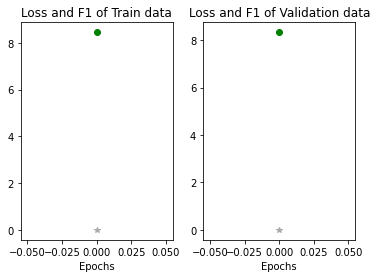

[I 2022-05-31 06:57:30,719] Trial 13 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0088029466, Avg Loss : 6.2969, f1 score : 0.3508
Epoch: 0, Step : 128, LR : 0.0076243094, Avg Loss : 4.9221, f1 score : 0.2726
Epoch: 0, Step : 192, LR : 0.0064456722, Avg Loss : 4.3086, f1 score : 0.2266
Epoch: 0, Step : 256, LR : 0.0052670350, Avg Loss : 4.1992, f1 score : 0.2242
Epoch: 0, Step : 320, LR : 0.0040883978, Avg Loss : 3.9596, f1 score : 0.2111
Epoch: 0, Step : 384, LR : 0.0029097606, Avg Loss : 3.5727, f1 score : 0.1974
Epoch: 0, Step : 448, LR : 0.0017311234, Avg Loss : 3.6979, f1 score : 0.1985
Epoch: 0, Step : 512, LR : 0.0005524862, Avg Loss : 3.3708, f1 score : 0.0727
Epoch 0 Total Mean Loss : 4.2247
Epoch 0 Total Mean f1 : 0.2138
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3050 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7883, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 2.0분 49.76598310470581초
green is loss, gray is f1


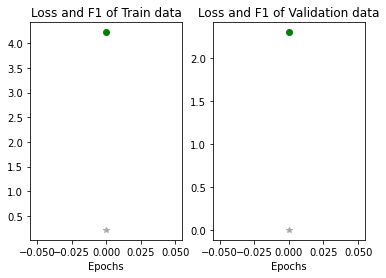

[I 2022-05-31 07:00:38,962] Trial 14 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000380515, Avg Loss : 1.2387, f1 score : 0.8069
Epoch: 0, Step : 128, LR : 0.0000262868, Avg Loss : 0.6455, f1 score : 0.8475
Epoch: 0, Step : 192, LR : 0.0000145221, Avg Loss : 0.5349, f1 score : 0.8703
Epoch: 0, Step : 256, LR : 0.0000027574, Avg Loss : 0.5548, f1 score : 0.8671
Epoch 0 Total Mean Loss : 0.7307
Epoch 0 Total Mean f1 : 0.8501
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 0.9470 Valid Acc : 0.7544 Valid f1 : 0.6965
pearson 상관 계수 ; tensor([[1.0000, 0.7233],
        [0.7233, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.4038, f1 score : 0.8905
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.3650, f1 score : 0.8957
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.4020, f1 score : 0.8875
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.3867, f1 score : 0.8960
Epoch 1 Total Mean Loss : 0.3888
Epoch 1 Total Mean f1 : 0.8933
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 0.9470 Valid Acc : 0.7544 Valid f1 : 0.6965
pearson 상관 계수 ; tensor([[1.0000, 0.7233],
        [0.7233, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.3736, f1 score : 0.8935
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.3890, f1 score : 0.8917
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.3824, f1 score : 0.8955
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.3861, f1 score : 0.8993
Epoch 2 Total Mean Loss : 0.3849
Epoch 2 Total Mean f1 : 0.8939
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 0.9470 Valid Acc : 0.7544 Valid f1 : 0.6965
pearson 상관 계수 ; tensor([[1.0000, 0.7233],
        [0.7233, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.3575, f1 score : 0.8971
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.4282, f1 score : 0.8863
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.3867, f1 score : 0.8935
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.3880, f1 score : 0.8942
Epoch 3 Total Mean Loss : 0.3870
Epoch 3 Total Mean f1 : 0.8936
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3 Valid Loss : 0.9470 Valid Acc : 0.7544 Valid f1 : 0.6965
pearson 상관 계수 ; tensor([[1.0000, 0.7233],
        [0.7233, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 9.0분 46.53360986709595초
green is loss, gray is f1


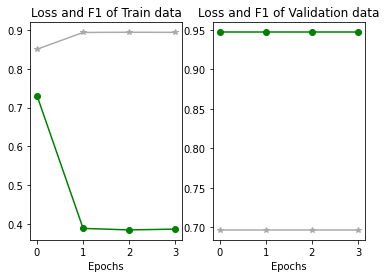

[I 2022-05-31 07:10:43,908] Trial 15 finished with value: 0.6964634613305738 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 5e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 272
model_name : snunlp/KR-Medium, lr : 2e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000152206, Avg Loss : 1.4859, f1 score : 0.8020
Epoch: 0, Step : 128, LR : 0.0000105147, Avg Loss : 0.6907, f1 score : 0.8351
Epoch: 0, Step : 192, LR : 0.0000058088, Avg Loss : 0.6118, f1 score : 0.8651
Epoch: 0, Step : 256, LR : 0.0000011029, Avg Loss : 0.6243, f1 score : 0.8474
Epoch 0 Total Mean Loss : 0.8379
Epoch 0 Total Mean f1 : 0.8388
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 1.0302 Valid Acc : 0.7456 Valid f1 : 0.7157
pearson 상관 계수 ; tensor([[1.0000, 0.6990],
        [0.6990, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 0.4852, f1 score : 0.8766
Epoch: 1, Step : 128, LR : 0.0000000000, Avg Loss : 0.5006, f1 score : 0.8766
Epoch: 1, Step : 192, LR : 0.0000000000, Avg Loss : 0.5036, f1 score : 0.8803
Epoch: 1, Step : 256, LR : 0.0000000000, Avg Loss : 0.4871, f1 score : 0.8731
Epoch 1 Total Mean Loss : 0.5002
Epoch 1 Total Mean f1 : 0.8761
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1 Valid Loss : 1.0302 Valid Acc : 0.7456 Valid f1 : 0.7157
pearson 상관 계수 ; tensor([[1.0000, 0.6990],
        [0.6990, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****

*****Epoch 2 Train Start*****
Epoch: 2, Step : 64, LR : 0.0000000000, Avg Loss : 0.5062, f1 score : 0.8716
Epoch: 2, Step : 128, LR : 0.0000000000, Avg Loss : 0.5148, f1 score : 0.8847
Epoch: 2, Step : 192, LR : 0.0000000000, Avg Loss : 0.4923, f1 score : 0.8752
Epoch: 2, Step : 256, LR : 0.0000000000, Avg Loss : 0.5041, f1 score : 0.8709
Epoch 2 Total Mean Loss : 0.5041
Epoch 2 Total Mean f1 : 0.8757
*****Epoch 2 Train Finish*****

*****Epoch 2 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2 Valid Loss : 1.0302 Valid Acc : 0.7456 Valid f1 : 0.7157
pearson 상관 계수 ; tensor([[1.0000, 0.6990],
        [0.6990, 1.0000]], device='cuda:0')
*****Epoch 2 Valid Finish*****

*****Epoch 3 Train Start*****
Epoch: 3, Step : 64, LR : 0.0000000000, Avg Loss : 0.4609, f1 score : 0.8875
Epoch: 3, Step : 128, LR : 0.0000000000, Avg Loss : 0.5313, f1 score : 0.8696
Epoch: 3, Step : 192, LR : 0.0000000000, Avg Loss : 0.5040, f1 score : 0.8724
Epoch: 3, Step : 256, LR : 0.0000000000, Avg Loss : 0.5131, f1 score : 0.8795
Epoch 3 Total Mean Loss : 0.5000
Epoch 3 Total Mean f1 : 0.8773
*****Epoch 3 Train Finish*****

*****Epoch 3 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3 Valid Loss : 1.0302 Valid Acc : 0.7456 Valid f1 : 0.7157
pearson 상관 계수 ; tensor([[1.0000, 0.6990],
        [0.6990, 1.0000]], device='cuda:0')
*****Epoch 3 Valid Finish*****

Train Finished
time : 9.0분 49.08056044578552초
green is loss, gray is f1


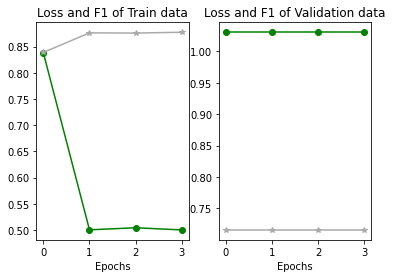

[I 2022-05-31 07:20:51,443] Trial 16 finished with value: 0.7157370847836799 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0088029466, Avg Loss : 8.5469, f1 score : 0.0201
Epoch: 0, Step : 128, LR : 0.0076243094, Avg Loss : 8.6511, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0064456722, Avg Loss : 8.4239, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0052670350, Avg Loss : 8.5083, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0040883978, Avg Loss : 8.6746, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0029097606, Avg Loss : 8.5487, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0017311234, Avg Loss : 8.0739, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0005524862, Avg Loss : 8.2467, f1 score : 0.0000
Epoch 0 Total Mean Loss : 8.4542
Epoch 0 Total Mean f1 : 0.0024
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 8.3324 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 8.4287, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 2.0분 50.13516449928284초
green is loss, gray is f1


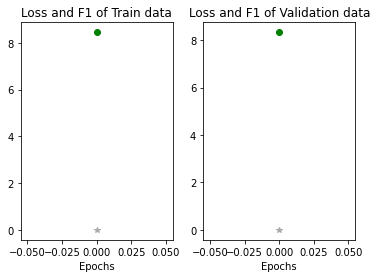

[I 2022-05-31 07:24:00,018] Trial 17 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0088029466, Avg Loss : 8.2008, f1 score : 0.0121
Epoch: 0, Step : 128, LR : 0.0076243094, Avg Loss : 8.8416, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0064456722, Avg Loss : 8.4640, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0052670350, Avg Loss : 8.3319, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0040883978, Avg Loss : 8.4493, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0029097606, Avg Loss : 8.3669, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0017311234, Avg Loss : 8.2676, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0005524862, Avg Loss : 8.6368, f1 score : 0.0000
Epoch 0 Total Mean Loss : 8.4406
Epoch 0 Total Mean f1 : 0.0014
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 8.3324 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 8.5275, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 2.0분 50.273885011672974초
green is loss, gray is f1


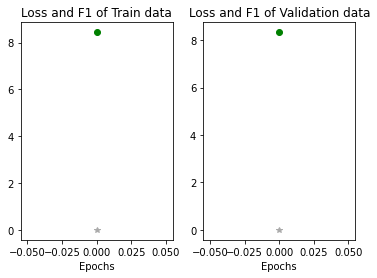

[I 2022-05-31 07:27:08,704] Trial 18 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total train steps with 1 epochs: 543
model_name : snunlp/KR-Medium, lr : 0.01, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0088029466, Avg Loss : 9.3964, f1 score : 0.5373
Epoch: 0, Step : 128, LR : 0.0076243094, Avg Loss : 9.7021, f1 score : 0.6666
Epoch: 0, Step : 192, LR : 0.0064456722, Avg Loss : 9.8060, f1 score : 0.6496
Epoch: 0, Step : 256, LR : 0.0052670350, Avg Loss : 9.6514, f1 score : 0.6578
Epoch: 0, Step : 320, LR : 0.0040883978, Avg Loss : 9.7854, f1 score : 0.6540
Epoch: 0, Step : 384, LR : 0.0029097606, Avg Loss : 9.8008, f1 score : 0.6581
Epoch: 0, Step : 448, LR : 0.0017311234, Avg Loss : 9.7181, f1 score : 0.6489
Epoch: 0, Step : 512, LR : 0.0005524862, Avg Loss : 9.5617, f1 score : 0.6577
Epoch 0 Total Mean Loss : 9.6615
Epoch 0 Total Mean f1 : 0.6428
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 8.7799 Valid Acc : 0.3880 Valid f1 : 0.5916
pearson 상관 계수 ; tensor([[nan, nan],
        [

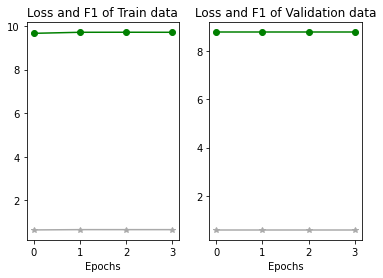

[I 2022-05-31 07:37:40,170] Trial 19 finished with value: 0.5916396361773036 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------




<Figure size 432x288 with 0 Axes>

In [80]:
print('snunlp/KR-Medium\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search') 
# Optimize the objective using 5 different trials 
study.optimize(objective, n_trials=20)

In [81]:
# Gives the best loss value 
print(study.best_value)
# Gives the best hyperparameter values to get the best loss value 
print(study.best_params)
# Return info about best Trial such as start and end datetime, hyperparameters  
print(study.best_trial)

0.0
{'per_device_train_batch_size': 64, 'learning_rate': 0.01}
FrozenTrial(number=0, values=[0.0], datetime_start=datetime.datetime(2022, 5, 31, 5, 27, 35, 266154), datetime_complete=datetime.datetime(2022, 5, 31, 5, 30, 51, 221862), params={'per_device_train_batch_size': 64, 'learning_rate': 0.01}, distributions={'per_device_train_batch_size': CategoricalDistribution(choices=(16, 32, 64)), 'learning_rate': CategoricalDistribution(choices=(5e-05, 3e-05, 2e-05, 0.0001, 0.001, 0.01))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


### 'monologg/kobert' 

[I 2022-05-31 12:50:35,539] A new study created in memory with name: hyper-parameter-search


monologg/kobert




Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

batch_size : 64
batch_size : 32


Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.1928, f1 score : 0.1219
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.8347, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8959, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8294, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9355
Epoch 0 Total Mean f1 : 0.0291
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3210 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8455, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 26.342170238494873초
green is loss, gray is f1


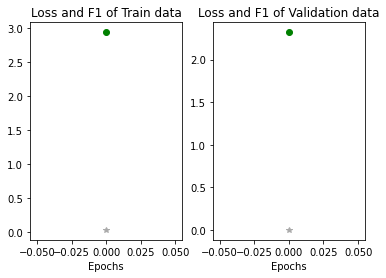

[I 2022-05-31 12:51:30,743] Trial 0 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000440147, Avg Loss : 2.8794, f1 score : 0.0000
Epoch: 0, Step : 128, LR : 0.0000381215, Avg Loss : 2.8469, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000322284, Avg Loss : 2.8858, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000263352, Avg Loss : 2.8685, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000204420, Avg Loss : 2.8556, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000145488, Avg Loss : 2.8214, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000086556, Avg Loss : 2.7530, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000027624, Avg Loss : 2.7217, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8334
Epoch 0 Total Mean f1 : 0.0000
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3140 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7812, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 41.48360991477966초
green is loss, gray is f1


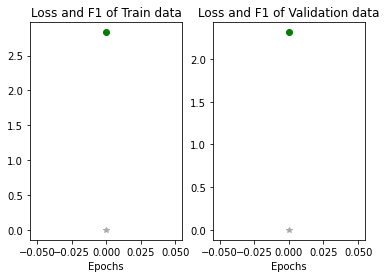

[I 2022-05-31 12:52:30,440] Trial 1 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000440147, Avg Loss : 2.8043, f1 score : 0.0163
Epoch: 0, Step : 128, LR : 0.0000381215, Avg Loss : 2.8955, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000322284, Avg Loss : 2.8479, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000263352, Avg Loss : 2.8506, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000204420, Avg Loss : 2.8178, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000145488, Avg Loss : 2.8560, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000086556, Avg Loss : 2.8459, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000027624, Avg Loss : 2.8222, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8401
Epoch 0 Total Mean f1 : 0.0019
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3100 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7708, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 41.13232707977295초
green is loss, gray is f1


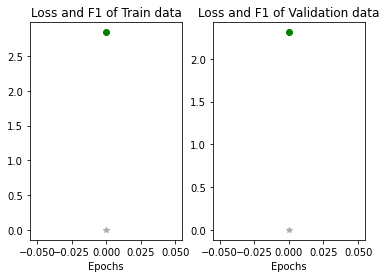

[I 2022-05-31 12:53:29,539] Trial 2 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000440147, Avg Loss : 2.9704, f1 score : 0.0151
Epoch: 0, Step : 128, LR : 0.0000381215, Avg Loss : 2.8497, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000322284, Avg Loss : 2.7797, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000263352, Avg Loss : 2.8203, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000204420, Avg Loss : 2.8016, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000145488, Avg Loss : 2.8124, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000086556, Avg Loss : 2.8658, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000027624, Avg Loss : 2.9081, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8445
Epoch 0 Total Mean f1 : 0.0018
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3120 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8201, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 43.82820987701416초
green is loss, gray is f1


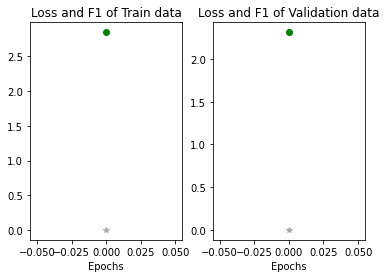

[I 2022-05-31 12:54:31,567] Trial 3 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.3493, f1 score : 0.1429
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 3.0932, f1 score : 0.0246
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 3.0138, f1 score : 0.0288
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.9454, f1 score : 0.0193
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.9095, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8426, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8385, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.7972, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9588
Epoch 0 Total Mean f1 : 0.0257
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3562 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8919, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 43.02120065689087초
green is loss, gray is f1


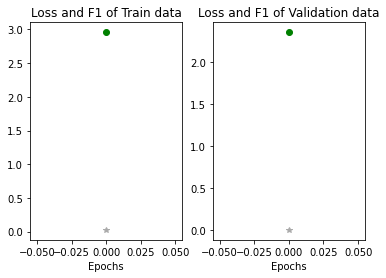

[I 2022-05-31 12:55:32,641] Trial 4 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.2286, f1 score : 0.1485
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.9079, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.9017, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.7664, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9483
Epoch 0 Total Mean f1 : 0.0355
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3123 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8326, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 26.094476461410522초
green is loss, gray is f1


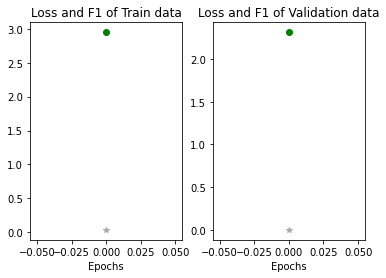

[I 2022-05-31 12:56:16,695] Trial 5 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 3e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000264088, Avg Loss : 2.7933, f1 score : 0.0000
Epoch: 0, Step : 128, LR : 0.0000228729, Avg Loss : 2.8558, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000193370, Avg Loss : 2.8731, f1 score : 0.0021
Epoch: 0, Step : 256, LR : 0.0000158011, Avg Loss : 2.9106, f1 score : 0.0016
Epoch: 0, Step : 320, LR : 0.0000122652, Avg Loss : 2.7421, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000087293, Avg Loss : 2.8472, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000051934, Avg Loss : 2.8438, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000016575, Avg Loss : 2.8739, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8373
Epoch 0 Total Mean f1 : 0.0004
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3115 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8049, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 42.03208589553833초
green is loss, gray is f1


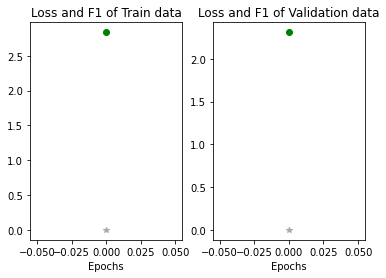

[I 2022-05-31 12:57:16,795] Trial 6 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 5e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000380515, Avg Loss : 2.8627, f1 score : 0.0000
Epoch: 0, Step : 128, LR : 0.0000262868, Avg Loss : 2.7996, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000145221, Avg Loss : 2.8511, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000027574, Avg Loss : 2.7864, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8309
Epoch 0 Total Mean f1 : 0.0000
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3154 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8310, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 27.212543487548828초
green is loss, gray is f1


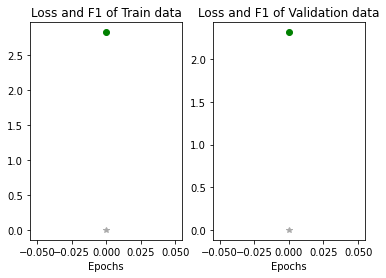

[I 2022-05-31 12:58:02,135] Trial 7 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 5e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0008802947, Avg Loss : 3.2586, f1 score : 0.1804
Epoch: 0, Step : 128, LR : 0.0007624309, Avg Loss : 2.8649, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0006445672, Avg Loss : 2.8995, f1 score : 0.0609
Epoch: 0, Step : 256, LR : 0.0005267035, Avg Loss : 2.8777, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0004088398, Avg Loss : 2.8656, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0002909761, Avg Loss : 2.8285, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0001731123, Avg Loss : 2.8618, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000552486, Avg Loss : 2.9034, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9200
Epoch 0 Total Mean f1 : 0.0288
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3121 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8595, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 42.981730222702026초
green is loss, gray is f1


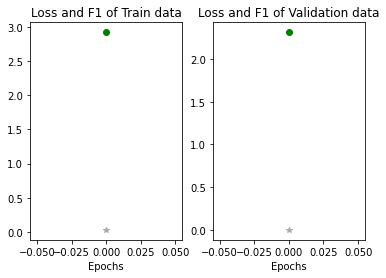

[I 2022-05-31 12:59:03,220] Trial 8 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.1140, f1 score : 0.0930
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.9067, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8647, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8640, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9347
Epoch 0 Total Mean f1 : 0.0222
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3069 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8083, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 26.679316997528076초
green is loss, gray is f1


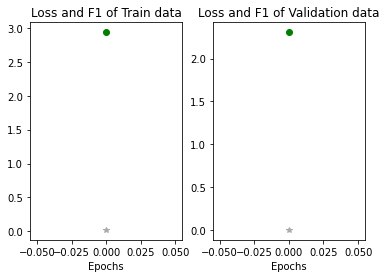

[I 2022-05-31 12:59:48,026] Trial 9 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 2e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000188029, Avg Loss : 2.8989, f1 score : 0.0000
Epoch: 0, Step : 128, LR : 0.0000176243, Avg Loss : 2.9022, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000164457, Avg Loss : 2.8744, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000152670, Avg Loss : 2.8445, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000140884, Avg Loss : 2.8947, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000129098, Avg Loss : 2.8732, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000117311, Avg Loss : 2.7941, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000105525, Avg Loss : 2.9890, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000093738, Avg Loss : 2.8154, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000081952, Avg Loss : 2.7779, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000070166, Avg Loss : 2.7410, f1 score : 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3120 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8294, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 17.17569613456726초
green is loss, gray is f1


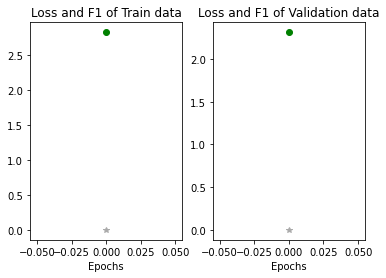

[I 2022-05-31 13:01:23,299] Trial 10 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 2e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 1e-06, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000009401, Avg Loss : 2.9229, f1 score : 0.0443
Epoch: 0, Step : 128, LR : 0.0000008812, Avg Loss : 2.8972, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000008223, Avg Loss : 2.8780, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000007634, Avg Loss : 2.9284, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000007044, Avg Loss : 2.8207, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000006455, Avg Loss : 2.7832, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000005866, Avg Loss : 2.8558, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000005276, Avg Loss : 2.8875, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000004687, Avg Loss : 2.6665, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000004098, Avg Loss : 2.8405, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000003508, Avg Loss : 2.7526, f1 score : 0.0000
E

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch: 0, Step : 1024, LR : 0.0000000562, Avg Loss : 2.8186, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8323
Epoch 0 Total Mean f1 : 0.0028
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3106 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8430, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 15.749200582504272초
green is loss, gray is f1


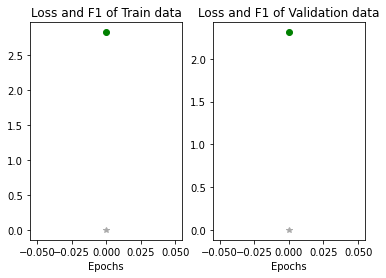

[I 2022-05-31 13:02:57,072] Trial 11 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 1e-06, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 1e-06, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000007610, Avg Loss : 2.8357, f1 score : 0.0000
Epoch: 0, Step : 128, LR : 0.0000005257, Avg Loss : 2.8998, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000002904, Avg Loss : 2.8254, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000000551, Avg Loss : 2.8364, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8435
Epoch 0 Total Mean f1 : 0.0000
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3309 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8206, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.93968391418457초
green is loss, gray is f1


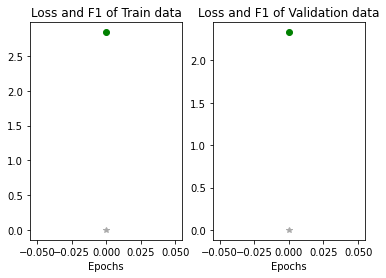

[I 2022-05-31 13:03:40,948] Trial 12 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 1e-06, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 2e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000152206, Avg Loss : 2.8608, f1 score : 0.0080
Epoch: 0, Step : 128, LR : 0.0000105147, Avg Loss : 2.8254, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000058088, Avg Loss : 2.8232, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000011029, Avg Loss : 2.7973, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8266
Epoch 0 Total Mean f1 : 0.0019
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3043 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8215, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.787965297698975초
green is loss, gray is f1


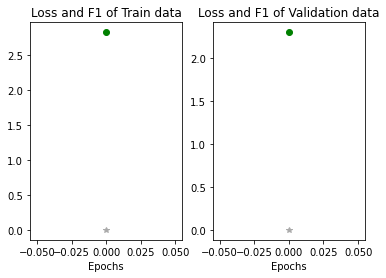

[I 2022-05-31 13:04:24,725] Trial 13 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 2e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 3e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 2.9651, f1 score : 0.0073
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 2.8500, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 2.8671, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 2.9520, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 2.8518, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 2.8718, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 2.7918, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 2.8213, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 2.8985, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 2.7761, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 2.8198, f1 score : 0.0000
E

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3116 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8159, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 11.498250007629395초
green is loss, gray is f1


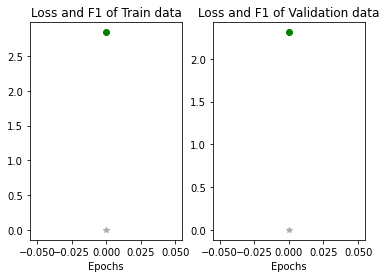

[I 2022-05-31 13:05:54,179] Trial 14 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 5e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000440147, Avg Loss : 2.9093, f1 score : 0.0539
Epoch: 0, Step : 128, LR : 0.0000381215, Avg Loss : 2.8536, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000322284, Avg Loss : 2.8523, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000263352, Avg Loss : 2.9107, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000204420, Avg Loss : 2.7931, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000145488, Avg Loss : 2.8282, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000086556, Avg Loss : 2.7769, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000027624, Avg Loss : 2.8572, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8435
Epoch 0 Total Mean f1 : 0.0064
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3122 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7626, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 39.713969230651855초
green is loss, gray is f1


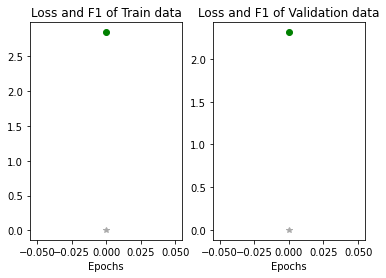

[I 2022-05-31 13:06:51,842] Trial 15 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.2844, f1 score : 0.1416
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.9027, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.9043, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8232, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9681
Epoch 0 Total Mean f1 : 0.0338
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3112 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8396, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.706265687942505초
green is loss, gray is f1


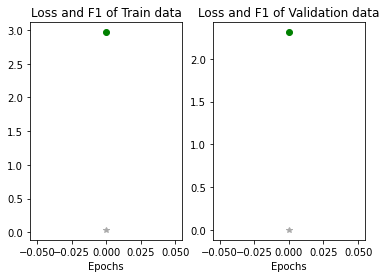

[I 2022-05-31 13:07:35,482] Trial 16 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 3e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 2.7840, f1 score : 0.0404
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 2.7699, f1 score : 0.0080
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 2.9193, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 2.8671, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 2.8291, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 2.7607, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 2.7978, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 2.8675, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 2.7880, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 2.8998, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 2.8882, f1 score : 0.0000
E

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3116 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.9135, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 11.798950672149658초
green is loss, gray is f1


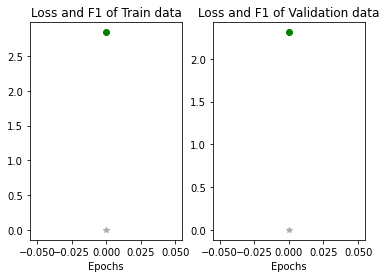

[I 2022-05-31 13:09:05,229] Trial 17 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 32
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 543
model_name : monologg/kobert, lr : 5e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000440147, Avg Loss : 2.8908, f1 score : 0.0239
Epoch: 0, Step : 128, LR : 0.0000381215, Avg Loss : 2.8615, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000322284, Avg Loss : 2.8994, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000263352, Avg Loss : 2.7572, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000204420, Avg Loss : 2.9164, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000145488, Avg Loss : 2.7252, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000086556, Avg Loss : 2.7353, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000027624, Avg Loss : 2.9000, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8363
Epoch 0 Total Mean f1 : 0.0029
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3106 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8027, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 40.50639724731445초
green is loss, gray is f1


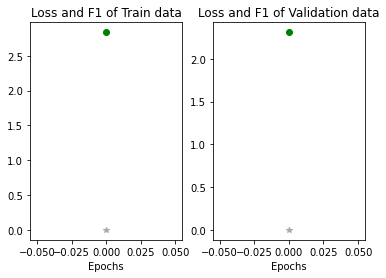

[I 2022-05-31 13:10:03,688] Trial 18 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 32, 'learning_rate': 5e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.2674, f1 score : 0.0706
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.9083, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8842, f1 score : 0.0162
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8393, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9699
Epoch 0 Total Mean f1 : 0.0207
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3062 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8630, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.676045179367065초
green is loss, gray is f1


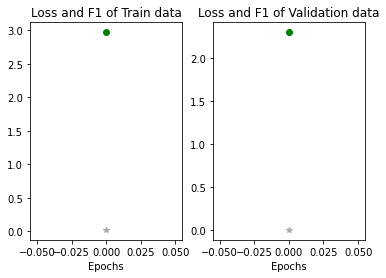

[I 2022-05-31 13:10:47,306] Trial 19 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 3e-05, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 2.8919, f1 score : 0.0000
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 2.7633, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 2.9134, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 2.9238, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 2.8652, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 2.7921, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 2.9291, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 2.7834, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 2.8445, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 2.8743, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 2.7243, f1 score : 0.0000
E

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3095 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7621, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 11.647213220596313초
green is loss, gray is f1


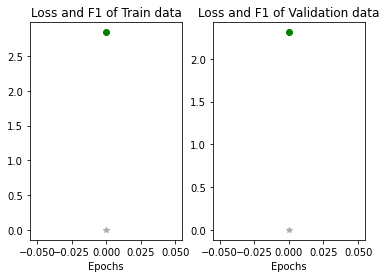

[I 2022-05-31 13:12:16,929] Trial 20 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 3e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 2.7830, f1 score : 0.0143
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 2.8263, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 2.8988, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 2.8194, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 2.8270, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 2.8451, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 2.9449, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 2.7937, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 2.8915, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 2.8498, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 2.8208, f1 score : 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3098 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8310, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 11.24004054069519초
green is loss, gray is f1


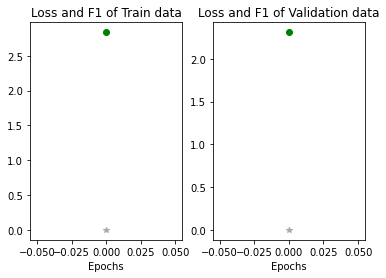

[I 2022-05-31 13:13:46,174] Trial 21 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.2424, f1 score : 0.1062
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.8909, f1 score : 0.0020
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8931, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8270, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9510
Epoch 0 Total Mean f1 : 0.0258
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3044 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7825, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.683982610702515초
green is loss, gray is f1


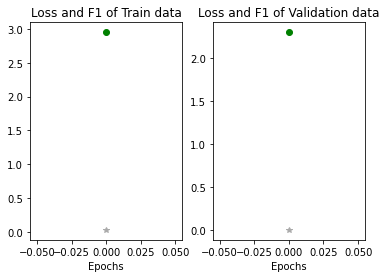

[I 2022-05-31 13:14:29,774] Trial 22 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 0.01, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.1903, f1 score : 0.0847
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.8969, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8435, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8643, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9431
Epoch 0 Total Mean f1 : 0.0202
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3051 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8691, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.631007432937622초
green is loss, gray is f1


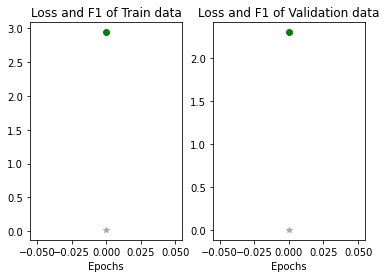

[I 2022-05-31 13:15:13,295] Trial 23 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 3e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000282044, Avg Loss : 2.7847, f1 score : 0.0000
Epoch: 0, Step : 128, LR : 0.0000264365, Avg Loss : 2.8840, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000246685, Avg Loss : 2.9302, f1 score : 0.0402
Epoch: 0, Step : 256, LR : 0.0000229006, Avg Loss : 2.8965, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000211326, Avg Loss : 2.8553, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000193646, Avg Loss : 2.8065, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000175967, Avg Loss : 2.8271, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000158287, Avg Loss : 2.7464, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000140608, Avg Loss : 2.8250, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000122928, Avg Loss : 2.8749, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000105249, Avg Loss : 2.7676, f1 score : 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3042 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8413, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 12.080098152160645초
green is loss, gray is f1


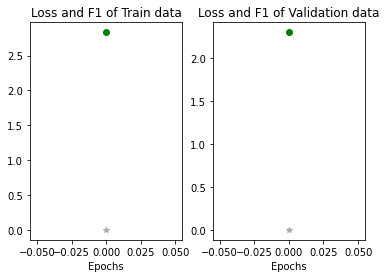

[I 2022-05-31 13:16:43,328] Trial 24 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.2042, f1 score : 0.0813
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.9222, f1 score : 0.0137
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8692, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8471, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9476
Epoch 0 Total Mean f1 : 0.0227
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3048 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8156, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.833764791488647초
green is loss, gray is f1


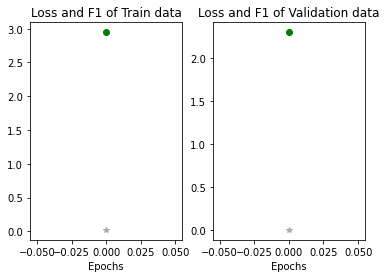

[I 2022-05-31 13:17:27,115] Trial 25 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.0878, f1 score : 0.0555
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.8496, f1 score : 0.0069
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.9106, f1 score : 0.0042
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8741, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9253
Epoch 0 Total Mean f1 : 0.0159
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3373 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8653, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.665904760360718초
green is loss, gray is f1


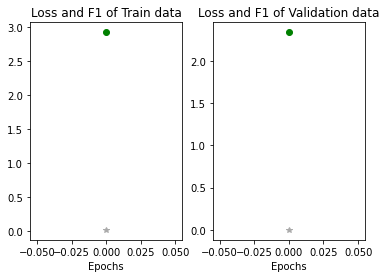

[I 2022-05-31 13:18:10,672] Trial 26 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 16
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 1086
model_name : monologg/kobert, lr : 1e-06, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000009401, Avg Loss : 2.7959, f1 score : 0.0031
Epoch: 0, Step : 128, LR : 0.0000008812, Avg Loss : 2.8319, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000008223, Avg Loss : 2.8317, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000007634, Avg Loss : 2.7967, f1 score : 0.0000
Epoch: 0, Step : 320, LR : 0.0000007044, Avg Loss : 2.8945, f1 score : 0.0000
Epoch: 0, Step : 384, LR : 0.0000006455, Avg Loss : 2.8742, f1 score : 0.0000
Epoch: 0, Step : 448, LR : 0.0000005866, Avg Loss : 2.7464, f1 score : 0.0000
Epoch: 0, Step : 512, LR : 0.0000005276, Avg Loss : 2.9134, f1 score : 0.0000
Epoch: 0, Step : 576, LR : 0.0000004687, Avg Loss : 2.7898, f1 score : 0.0000
Epoch: 0, Step : 640, LR : 0.0000004098, Avg Loss : 2.8467, f1 score : 0.0000
Epoch: 0, Step : 704, LR : 0.0000003508, Avg Loss : 2.8774, f1 score : 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3056 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.8582, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 1.0분 11.34477162361145초
green is loss, gray is f1


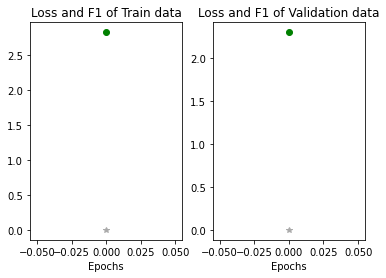

[I 2022-05-31 13:19:39,905] Trial 27 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 16, 'learning_rate': 1e-06, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 2e-05, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000152206, Avg Loss : 2.8621, f1 score : 0.0047
Epoch: 0, Step : 128, LR : 0.0000105147, Avg Loss : 2.8598, f1 score : 0.0000
Epoch: 0, Step : 192, LR : 0.0000058088, Avg Loss : 2.8249, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000011029, Avg Loss : 2.8064, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.8367
Epoch 0 Total Mean f1 : 0.0011
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3090 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7864, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.665176391601562초
green is loss, gray is f1


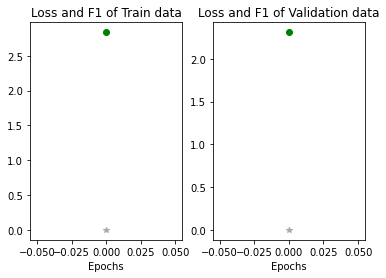

[I 2022-05-31 13:20:23,521] Trial 28 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 2e-05, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------


batch_size : 64
batch_size : 32


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total train steps with 1 epochs: 272
model_name : monologg/kobert, lr : 0.001, weight_decay : 4e-05, epochs : 1
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0007610294, Avg Loss : 3.1197, f1 score : 0.0392
Epoch: 0, Step : 128, LR : 0.0005257353, Avg Loss : 2.9064, f1 score : 0.0511
Epoch: 0, Step : 192, LR : 0.0002904412, Avg Loss : 2.8053, f1 score : 0.0000
Epoch: 0, Step : 256, LR : 0.0000551471, Avg Loss : 2.8950, f1 score : 0.0000
Epoch 0 Total Mean Loss : 2.9261
Epoch 0 Total Mean f1 : 0.0214
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0 Valid Loss : 2.3206 Valid Acc : 0.5593 Valid f1 : 0.0000
pearson 상관 계수 ; tensor([[nan, nan],
        [nan, 1.]], device='cuda:0')
*****Epoch 0 Valid Finish*****

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000000000, Avg Loss : 2.7919, f1 score : 0.0000
Train Finished, learning_rate is 0 and train_f1 is 0
time : 0.0분 25.66938805580139초
green is loss, gray is f1


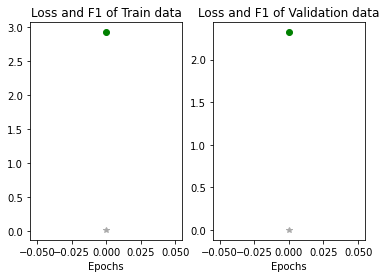

[I 2022-05-31 13:21:07,173] Trial 29 finished with value: 0.0 and parameters: {'per_device_train_batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 4e-05}. Best is trial 0 with value: 0.0.



------------------------------------------




<Figure size 432x288 with 0 Axes>

In [34]:
print('monologg/kobert\n\n')
study = optuna.create_study(study_name='hyper-parameter-search') 
study.optimize(objective, n_trials=30)

In [ ]:

# Gives the best loss value 
print(study.best_value)
# Gives the best hyperparameter values to get the best loss value 
print(study.best_params)
# Return info about best Trial such as start and end datetime, hyperparameters  
print(study.best_trial)
print('klue/bert-base\n\n')
# We want to minimize the loss! 
study = optuna.create_study(study_name='hyper-parameter-search') 
study.optimize(objective, n_trials=30)
print(study.best_trial.value) 
print(study.best_params) 
print(study.trials)
optuna.visualization.plot_edf(study)

### Train : 'snunlp/KR-Medium'

- batch_size : {train : 32, valid : 32} -> 0.7779  

*****Epoch 11 Train Start*****
Epoch: 11, Step : 64, LR : 0.0000, Avg Loss : 0.0205, f1 score : 1.0000  
Epoch: 11, Step : 128, LR : 0.0000, Avg Loss : 0.0220, f1 score : 1.0000  
Epoch: 11, Step : 192, LR : 0.0000, Avg Loss : 0.0213, f1 score : 0.9714  
Epoch: 11, Step : 256, LR : 0.0000, Avg Loss : 0.0187, f1 score : 0.9730  
Epoch: 11, Step : 320, LR : 0.0000, Avg Loss : 0.0209, f1 score : 1.0000  
Epoch 11 Total Mean Loss : 0.0207  
*****Epoch 11 Train Finish*****

*****Epoch 11 Valid Start*****  
Epoch 11 Valid Loss : 0.5886 Valid Acc : 79.02 Valid f1 : 0.7779  
*****Epoch 11 Valid Finish*****

- batch_size : {train : 64, valid : 64} -> 0.7416  

*****Epoch 18 Train Start*****
Epoch: 18, Step : 64, LR : 0.0000016448, Avg Loss : 0.0165, f1 score : 0.9832  
Epoch: 18, Step : 128, LR : 0.0000012951, Avg Loss : 0.0155, f1 score : 1.9829  
Epoch 18 Total Mean Loss : 0.0157  
*****Epoch 18 Train Finish*****

*****Epoch 18 Valid Start*****  
Epoch 18 Valid Loss : 0.5866 Valid Acc : 76.6617 Valid f1 : 0.7416  
pearson 상관 계수 ; tensor([[1.0000, 0.8644],  
        [0.8644, 1.0000]], device='cuda:0')

In [ ]:
train_batch_size, valid_batch_size = 32, 32
train_dataloader, valid_dataloader = make_dataloader(dataset, "snunlp/KR-Medium", train_batch_size, valid_batch_size)
epochs=20
model, optimizer, scheduler = initializer(train_dataloader, epochs, "snunlp/KR-Medium")

t0 = time.time()
train(model, train_dataloader, valid_dataloader, epochs)
print(time.time()-t0)

Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depr

Total train steps with 20 epochs: 7300
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000, Avg Loss : 1.6681, f1 score : 0.9286
Epoch: 0, Step : 128, LR : 0.0000, Avg Loss : 0.3266, f1 score : 1.0000
Epoch: 0, Step : 192, LR : 0.0000, Avg Loss : 0.2903, f1 score : 0.8000
Epoch: 0, Step : 256, LR : 0.0000, Avg Loss : 0.2625, f1 score : 0.9167
Epoch: 0, Step : 320, LR : 0.0000, Avg Loss : 0.2438, f1 score : 1.0000
Epoch 0 Total Mean Loss : 0.5240
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8607 Valid Acc : 70.54 Valid f1 : 0.7144
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/model0_loss:0.5240_f1:0.7144.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000, Avg Loss : 0.1896, f1 score : 1.0000
Epoch: 1, Step : 128, LR : 0.0000, Avg Loss : 0.1573, f1 score : 0.9333
Epoch: 1, Step : 192, LR : 0.0000, Avg Loss : 0.1561, f1 score : 0.9677
Epoch: 1, Step : 256, LR : 0.0

In [ ]:
if valid_dataloader is not None:
    valid_loss, valid_acc, valid_f1, valid_pearson = validate(model, valid_dataloader)
    print(f"Epoch 1 Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.2f} Valid f1 : {valid_f1:.4f}")
    print(f"pearson 상관 계수 ; {valid_pearson}")
    print(f"*****Epoch 1 Valid Finish*****\n")

Epoch 1 Valid Loss : 0.5634 Valid Acc : 79.02 Valid f1 : 0.7773
pearson 상관 계수 ; tensor([[1.0000, 0.8687],
        [0.8687, 1.0000]], device='cuda:0')
*****Epoch 1 Valid Finish*****



In [ ]:
train_batch_size, valid_batch_size = 64, 64
train_dataloader, valid_dataloader = make_dataloader(dataset, "snunlp/KR-Medium", train_batch_size, valid_batch_size)
epochs=20
model, optimizer, scheduler = initializer(train_dataloader, epochs, "snunlp/KR-Medium")

t0 = time.time()
train(model, train_dataloader, valid_dataloader, epochs)
print(time.time()-t0)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/140k [00:00<?, ?B/s]

<class 'torch.utils.data.dataloader.DataLoader'>


Downloading:   0%|          | 0.00/389M [00:00<?, ?B/s]

Some weights of the model checkpoint at snunlp/KR-Medium were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depr

Total train steps with 20 epochs: 3660
*****Epoch 0 Train Start*****
Epoch: 0, Step : 64, LR : 0.0000196448, Avg Loss : 1.2513, f1 score : 0.8761
Epoch: 0, Step : 128, LR : 0.0000192951, Avg Loss : 0.3020, f1 score : 1.8197
Epoch 0 Total Mean Loss : 0.6297
*****Epoch 0 Train Finish*****

*****Epoch 0 Valid Start*****
Epoch 0 Valid Loss : 0.8089 Valid Acc : 71.2798 Valid f1 : 0.6892
pearson 상관 계수 ; tensor([[1.0000, 0.7987],
        [0.7987, 1.0000]], device='cuda:0')
*****Epoch 0 Valid Finish*****

Saving epoch 0 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/model0_loss:0.8089_f1:0.6892.ckpt
*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000186448, Avg Loss : 0.1875, f1 score : 0.9514
Epoch: 1, Step : 128, LR : 0.0000182951, Avg Loss : 0.1827, f1 score : 1.9202
Epoch 1 Total Mean Loss : 0.1818
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Epoch 1 Valid Loss : 0.7495 Valid Acc : 72.1478 Valid f1 : 0.7061
pearson 상관 계수 ; tensor([[1.0000, 0.8226],
   

### Train : 'monologg/kobert' => X
[git](https://github.com/monologg/KoBERT-Transformers)

- sub task에 sts가 없음
- NSMC, NER, KorQuAD

*****Epoch 13 Train Start*****
Epoch: 13, Step : 64, LR : 0.0000068219, Avg Loss : 0.6886, f1 score : 0.8889  
Epoch: 13, Step : 128, LR : 0.0000066466, Avg Loss : 0.6039, f1 score : 0.9032  
Epoch: 13, Step : 192, LR : 0.0000064712, Avg Loss : 0.6317, f1 score : 0.8205  
Epoch: 13, Step : 256, LR : 0.0000062959, Avg Loss : 0.7305, f1 score : 0.9231  
Epoch: 13, Step : 320, LR : 0.0000061205, Avg Loss : 0.6926, f1 score : 0.9091  
Epoch 13 Total Mean Loss : 0.6849  
*****Epoch 13 Train Finish*****  

*****Epoch 13 Valid Start*****  
Epoch 13 Valid Loss : 3.0136 Valid Acc : 56.57 Valid f1 : 0.5553  
pearson 상관 계수 ; tensor([[1.0000, 0.2725],  
        [0.2725, 1.0000]], device='cuda:0')  
*****Epoch 13 Valid Finish*****

### train : 'klue/bert-base'
batch_size : {train : 32, valid : 32}
- Epoch 15 : 가장 작은 valid_loss를 가지고 있다.
  - Valid Loss : 0.3798
  - Valid Acc : 81.75
  - Valid f1 : 0.8095
  - pearson 상관 계수 : [[1.0000, 0.9116],[0.9116, 1.0000]]

*****Epoch 3 Train Start*****  
Epoch: 3, Step : 64, LR : 0.0000168219, Avg Loss : 0.0569, f1 score : 1.0000  
Epoch: 3, Step : 128, LR : 0.0000166466, Avg Loss : 0.0606, f1 score : 0.8696  
Epoch: 3, Step : 192, LR : 0.0000164712, Avg Loss : 0.0598, f1 score : 0.9630  
Epoch: 3, Step : 256, LR : 0.0000162959, Avg Loss : 0.0601, f1 score : 1.0000  
Epoch: 3, Step : 320, LR : 0.0000161205, Avg Loss : 0.0594, f1 score : 1.0000  
Epoch 3 Total Mean Loss : 0.0588  
*****Epoch 3 Train Finish*****  

*****Epoch 3 Valid Start*****  
Epoch 3 Valid Loss : 0.4417 Valid Acc : 82.67 Valid f1 : 0.8238  
pearson 상관 계수 ; tensor([[1.0000, 0.8983],  
        [0.8983, 1.0000]], device='cuda:0')  
*****Epoch 3 Valid Finish*****  

### Train : 'klue/bert-base'
train_batch_size, valid_batch_size = 64, 64

*****Epoch 1 Train Start*****
Epoch: 1, Step : 64, LR : 0.0000186448, Avg Loss : 0.1369, f1 score : 0.9609  
Epoch: 1, Step : 128, LR : 0.0000182951, Avg Loss : 0.1365, f1 score : 0.9631  
Epoch 1 Total Mean Loss : 0.1387  
*****Epoch 1 Train Finish*****  

*****Epoch 1 Valid Start*****  
Epoch 1 Valid Loss : 0.6064 Valid Acc : 79.0923 Valid f1 : 0.8043  
pearson 상관 계수 ; tensor([[1.0000, 0.8772],  
        [0.8772, 1.0000]], device='cuda:0')  
*****Epoch 1 Valid Finish*****

In [ ]:
train_batch_size, valid_batch_size = 64, 64
train_dataloader, valid_dataloader = make_dataloader(dataset, 'klue/bert-base', train_batch_size, valid_batch_size)
epochs=20
model, optimizer, scheduler = initializer(train_dataloader, epochs, 'klue/bert-base')

start = time.time()
train(model, train_dataloader, valid_dataloader, epochs)
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

### Train : 'klue/bert-base' 
특수문자, 영어 제거

- train_batch_size, valid_batch_size = 64, 64

*****Epoch 4 Train Start*****  
Epoch: 4, Step : 64, LR : 0.0000156448, Avg Loss : 0.0564, f1 score : 0.9768  
Epoch: 4, Step : 128, LR : 0.0000152951, Avg Loss : 0.0563, f1 score : 0.9760  
Epoch 4 Total Mean Loss : 0.0554  
*****Epoch 4 Train Finish*****  

*****Epoch 4 Valid Start*****  
Epoch 4 Valid Loss : 0.4984 Valid Acc : 80.4812 Valid f1 : 0.8143  
pearson 상관 계수 ; tensor([[1.0000, 0.8960],  
        [0.8960, 1.0000]], device='cuda:0')  
*****Epoch 4 Valid Finish*****


- train_batch_size, valid_batch_size = 128, 64

*****Epoch 6 Train Start*****  
Epoch: 6, Step : 64, LR : 0.0000132935, Avg Loss : 0.0471, f1 score : 0.9787
Epoch 6 Total Mean Loss : 0.0472  
*****Epoch 6 Train Finish*****

*****Epoch 6 Valid Start*****  
Epoch 6 Valid Loss : 0.4601 Valid Acc : 79.7619 Valid f1 : 0.7899  
pearson 상관 계수 ; tensor([[1.0000, 0.8956],  
        [0.8956, 1.0000]], device='cuda:0')  
*****Epoch 6 Valid Finish*****

- train_batch_size, valid_batch_size = 32, 32

*****Epoch 18 Train Start*****
Epoch: 18, Step : 64, LR : 0.0000018219, Avg Loss : 0.0083, f1 score : 0.9913  
Epoch: 18, Step : 128, LR : 0.0000016466, Avg Loss : 0.0082, f1 score : 0.9889  
Epoch: 18, Step : 192, LR : 0.0000014712, Avg Loss : 0.0080, f1 score : 0.9879  
Epoch: 18, Step : 256, LR : 0.0000012959, Avg Loss : 0.0080, f1 score : 0.9856  
Epoch: 18, Step : 320, LR : 0.0000011205, Avg Loss : 0.0080, f1 score : 0.9838  
Epoch 18 Total Mean Loss : 0.0081  
*****Epoch 18 Train Finish*****

*****Epoch 18 Valid Start*****  
Epoch 18 Valid Loss : 0.3956 Valid Acc : 82.9569 Valid f1 : 0.8279
pearson 상관 계수 ; tensor([[1.0000, 0.9100],
        [0.9100, 1.0000]], device='cuda:0')
*****Epoch 18 Valid Finish*****

## Train : 'klue/bert-base'
특수문자, 영어 제거

train_batch_size, valid_batch_size = 16, 16

*****Epoch 13 Train Start*****
Epoch: 13, Step : 64, LR : 0.0000069110, Avg Loss : 0.0098, f1 score : 0.9841
Epoch: 13, Step : 128, LR : 0.0000068233, Avg Loss : 0.0106, f1 score : 1.9811
Epoch: 13, Step : 192, LR : 0.0000067356, Avg Loss : 0.0090, f1 score : 2.9685
Epoch: 13, Step : 256, LR : 0.0000066479, Avg Loss : 0.0109, f1 score : 3.9450
Epoch: 13, Step : 320, LR : 0.0000065603, Avg Loss : 0.0104, f1 score : 4.9301
Epoch: 13, Step : 384, LR : 0.0000064726, Avg Loss : 0.0101, f1 score : 5.9050
Epoch: 13, Step : 448, LR : 0.0000063849, Avg Loss : 0.0094, f1 score : 6.9002
Epoch: 13, Step : 512, LR : 0.0000062973, Avg Loss : 0.0092, f1 score : 7.8838
Epoch: 13, Step : 576, LR : 0.0000062096, Avg Loss : 0.0096, f1 score : 8.8713
Epoch: 13, Step : 640, LR : 0.0000061219, Avg Loss : 0.0098, f1 score : 9.8627
Epoch: 13, Step : 704, LR : 0.0000060342, Avg Loss : 0.0094, f1 score : 10.8482
Epoch 13 Total Mean Loss : 0.0098
Epoch 13 Total Mean f1 : 0.9851
*****Epoch 13 Train Finish*****

*****Epoch 13 Valid Start*****
Epoch 13 Valid Loss : 0.3800 Valid Acc : 83.8745 Valid f1 : 0.8302
pearson 상관 계수 ; tensor([[1.0000, 0.9129],
        [0.9129, 1.0000]], device='cuda:0')
*****Epoch 13 Valid Finish*****

Saving epoch 13 checkpoint at /content/drive/MyDrive/Colab Notebooks/nlp/model13_loss:0.3800_f1:0.8302.ckpt

In [ ]:
train_batch_size, valid_batch_size = 64, 32
train_dataloader = make_dataloader(train_dataset, 'klue/bert-base', train_batch_size, 'train')
valid_dataloader = make_dataloader(valid_dataset, 'klue/bert-base', valid_batch_size, 'valid')
model, optimizer, scheduler = initializer(train_dataloader, 1, 'klue/bert-base', 4e-5, 4e-5)
train_dict, valid_dict = train(model, optimizer, scheduler, train_dataloader, valid_dataloader, 4, 'klue/bert-base')
start = time.time()
end = time.time()
print(f"time : {(end - start)//60}분 {(end - start)%60}초")

In [30]:
gc.collect()

3173